<a href="https://colab.research.google.com/github/Marshal-Kalynchuk/crypto-lstm-prediction/blob/main/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialize

In [ ]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer, LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

#!pip install ta
import ta.momentum
import ta.volume
import ta.volatility
import ta.trend


Num GPUs Available:  1


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


# Preprocess

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd

class IQRBasedOutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, n_std=1.5, lower_quantile=0.25, upper_quantile=0.75, handle_na='ignore'):
        self.n_std = n_std
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile
        self.handle_na = handle_na

    def fit(self, X, y=None):
        if self.handle_na == 'ignore':
            X = X.dropna()

        if isinstance(X, pd.DataFrame):
            self.upper_bound_ = X.quantile(self.upper_quantile) + (X.quantile(self.upper_quantile) - X.quantile(self.lower_quantile)) * self.n_std
            self.lower_bound_ = X.quantile(self.lower_quantile) - (X.quantile(self.upper_quantile) - X.quantile(self.lower_quantile)) * self.n_std
        else:
            q75, q25 = np.percentile(X, [self.upper_quantile * 100, self.lower_quantile * 100], axis=0)
            iqr = q75 - q25
            self.upper_bound_ = q75 + iqr * self.n_std
            self.lower_bound_ = q25 - iqr * self.n_std
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        if isinstance(X, pd.DataFrame):
            for column in X_copy.columns:
                X_copy.loc[X_copy[column] > self.upper_bound_[column], column] = np.nan
                X_copy.loc[X_copy[column] < self.lower_bound_[column], column] = np.nan
        else:
            for i in range(X_copy.shape[1]):
                X_copy[:, i] = np.where((X_copy[:, i] > self.upper_bound_[i]) |
                                        (X_copy[:, i] < self.lower_bound_[i]), np.nan, X_copy[:, i])
        return X_copy


In [ ]:
class SMAImputer(TransformerMixin):
    """
    Custom Simple Moving Average (SMA) Imputer for filling missing values in a pandas DataFrame.
    """
    def __init__(self, window=7, min_periods=1):
        self.window = window
        self.min_periods = min_periods

    def fit(self, X, y=None):
        # Nothing to do here for fitting process
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame")

        # Work on a copy of the DataFrame to avoid modifying the original data
        X_transformed = X.copy()
        for column in X_transformed.columns:
            X_transformed[column] = X_transformed[column].fillna(
                X_transformed[column].rolling(window=self.window, min_periods=self.min_periods).mean()
            )
        return X_transformed



In [ ]:
from sklearn.base import TransformerMixin
import pandas as pd

class FillImputer(TransformerMixin):
    """
    Custom imputer that first applies forward fill (ffill) and then backward fill (bfill)
    to handle any remaining missing values in a pandas DataFrame.
    """
    def fit(self, X, y=None):
        # Nothing to do here for fitting process
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame")

        # Work on a copy of the DataFrame to avoid modifying the original data
        X_transformed = X.copy()
        for column in X_transformed.columns:
            X_transformed[column] = X_transformed[column].fillna(method='ffill').fillna(method='bfill')
        return X_transformed


In [ ]:

def add_momentum_indicators(df, short_window, medium_window, long_window, fill_na=False):
    df['rsi'] = ta.momentum.RSIIndicator(df['close'], window=short_window, fillna=fill_na).rsi()
    df['stoch'] = ta.momentum.StochasticOscillator(df['high'], df['low'], df['close'], window=short_window, smooth_window=short_window//2, fillna=fill_na).stoch()
    df['roc'] = ta.momentum.ROCIndicator(df['close'], window=short_window, fillna=fill_na).roc()
    return df

def add_volume_indicators(df, short_window, medium_window, long_window,  fill_na=False):
    df['mfi'] = ta.volume.MFIIndicator(df['high'], df['low'], df['close'], df['volume'], window=short_window, fillna=fill_na).money_flow_index()
    df['mass'] = ta.trend.MassIndex(df['high'], df['low'], window_fast=short_window, window_slow=medium_window, fillna=fill_na).mass_index()
    return df

def add_volatility_indicators(df, short_window, medium_window, long_window, fill_na=False):
    ta.volatility.ulcer_index
    df['atr'] = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close'], window=short_window, fillna=fill_na).average_true_range()
    return df

def add_trend_indicators(df, short_window, medium_window, long_window,  fill_na=False):
    df['cci'] = ta.trend.CCIIndicator(df['high'], df['low'], df['close'], window=short_window, fillna=fill_na).cci()
    df['macd'] = ta.trend.MACD(df['close'], window_slow=medium_window, window_fast=short_window, fillna=fill_na).macd_diff()
    df['adx'] = ta.trend.ADXIndicator(df['high'], df['low'], df['close'], window=medium_window, fillna=fill_na).adx()
    df['vortex_indicator'] = ta.trend.VortexIndicator(df['high'], df['low'], df['close'], window=medium_window, fillna=fill_na).vortex_indicator_diff()
    return df

def add_other_indicators(df, short_window, medium_window, long_window, fill_na=False):
    df['dpo'] = ta.trend.DPOIndicator(df['close'], window=medium_window, fillna=fill_na).dpo()
    df['kst'] = ta.trend.KSTIndicator(df['close'], roc1=short_window//2, roc2=short_window, roc3=medium_window, roc4=long_window, window1=short_window//2, window2=short_window, window3=medium_window, window4=long_window, nsig=medium_window, fillna=fill_na).kst_sig()
    df['parabolic_sar'] = ta.trend.PSARIndicator(df['high'], df['low'], df['close']).psar()
    df['force_index'] = (df['close'].diff() * df['volume']).fillna(0)
    return df


def add_technical_indicators(df, short_window=6, medium_window=12, long_window=24, fill_na=False):
    df = add_momentum_indicators(df, short_window, medium_window, long_window, fill_na)
    df = add_volume_indicators(df, short_window, medium_window, long_window, fill_na)
    df = add_volatility_indicators(df, short_window, medium_window, long_window, fill_na)
    df = add_trend_indicators(df, short_window, medium_window, long_window, fill_na)
    df = add_other_indicators(df, short_window, medium_window, long_window, fill_na)
    return df


In [ ]:

def standardize_time(df):
    """
    Convert 'time' column from milliseconds to a standard datetime format.
    """
    df['time'] = pd.to_datetime(df['time'], unit='ms')
    return df

def load_and_format_data(path):
    """
    Load data from a given path, convert specific columns to float, and standardize time.
    """
    df = pd.read_csv(path)
    columns_to_convert = ['open', 'close', 'high', 'low', 'volume']
    df[columns_to_convert] = df[columns_to_convert].astype(float)
    df = standardize_time(df)
    return df

def impute_price_columns(df):
    """
    Impute missing values in price columns using a pipeline of SMA and fill imputation strategies.
    """
    price_columns = ['open', 'high', 'low', 'close']
    price_imputer = Pipeline([
        ('sma_imputer', SMAImputer(window=7)),
        ('fill_imputer', FillImputer())
    ])
    df[price_columns] = price_imputer.fit_transform(df[price_columns])
    return df

def resample_data(df, freq):
    """
    Resample data to a specified frequency and aggregate corresponding columns.
    """
    df.set_index('time', inplace=True)
    df = df.resample(freq).agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum'
    }).reset_index()
    return df


In [ ]:
import numpy as np

def calculate_log_returns(df, n_future):
    """
    Calculate the logarithmic returns for the 'close' price.

    Args:
    df (DataFrame): DataFrame containing the 'close' price column.
    n_future (int): Number of periods to calculate the future log return.

    Returns:
    DataFrame: Updated DataFrame with current and future log returns.
    """
    # Calculate current log returns
    df['log_return'] = np.log(df['close'] / df['close'].shift(1))

    # Calculate future log returns from today to n_future days ahead
    # This assumes your dataframe is sorted in ascending date order
    df['log_return_future'] = -np.log(df['close'] / df['close'].shift(n_future))

    return df


def calculate_log_ratio(df):
    df['log_ratio'] = np.log(df['close'] / df['open'])
    return df


def calculate_wicks(df):
    """
    Calculate the wick lengths of candles in a DataFrame. The DataFrame is expected
    to have columns 'open', 'close', 'high', and 'low'.

    Parameters:
    - df (pd.DataFrame): The DataFrame with the financial candle data.

    Returns:
    - pd.DataFrame: A DataFrame with new columns 'low_wick' and 'high_wick' representing
                    the lengths of the lower and upper wicks of each candle.
    """
    # Calculate the difference to determine if the candle went up or down
    df['diff'] = df['close'] - df['open']

    # Initialize columns to avoid KeyError
    df['low_wick'] = 0
    df['high_wick'] = 0

    # Calculate wicks for candles that went up
    df.loc[df['diff'] > 0, 'low_wick'] = df['open'] - df['low']
    df.loc[df['diff'] > 0, 'high_wick'] = df['high'] - df['close']

    # Calculate wicks for candles that went down or didn't move
    df.loc[df['diff'] <= 0, 'low_wick'] = df['close'] - df['low']
    df.loc[df['diff'] <= 0, 'high_wick'] = df['high'] - df['open']

    # Drop the diff column if no longer needed
    df.drop(columns=['diff'], inplace=True)

    return df

data = {
    'open': [100, 105, 103],
    'close': [105, 100, 103],
    'high': [106, 106, 104],
    'low': [98, 99, 102]
}
df = pd.DataFrame(data)

# Calculate wicks
result_df = calculate_wicks(df)
print(result_df)

   open  close  high  low  low_wick  high_wick
0   100    105   106   98         2          1
1   105    100   106   99         1          1
2   103    103   104  102         1          1


In [ ]:
ATR_HIGH_VOL_HOLD = 0.75

def sort_thresholds(thresholds):
    buy_thresholds, sell_thresholds = thresholds
    return sorted(buy_thresholds), sorted(sell_thresholds)

def process_buy_signals(df, buy_thresholds):
    for i in range(1, len(buy_thresholds)):
        inner_bound = buy_thresholds[i-1]
        outer_bound = buy_thresholds[i]
        df.loc[(df['log_return_future'] > inner_bound) & (df['log_return_future'] <= outer_bound), 'target'] = i
    return df

def process_sell_signals(df, sell_thresholds):
    for i in range(1, len(sell_thresholds)):
        inner_bound = sell_thresholds[i]
        outer_bound = sell_thresholds[i-1]
        df.loc[(df['log_return_future'] < inner_bound) & (df['log_return_future'] >= outer_bound), 'target'] = -i
    return df

def handle_hold_conditions(df, buy_thresholds, sell_thresholds):
    df.loc[(df['log_return_future'] >= sell_thresholds[-1]) & (df['log_return_future'] <= buy_thresholds[0]), 'target'] = 0
    df.loc[(df['log_return_future'] <= sell_thresholds[0]) | (df['log_return_future'] >= buy_thresholds[-1]), 'target'] = 0
    df = handle_high_volatility_hold(df)
    return df

def handle_high_volatility_hold(df):
    # Define the high volatility threshold, e.g., ATR value above 75th percentile
    high_volatility_threshold = df['atr'].quantile(ATR_HIGH_VOL_HOLD)
    df.loc[df['atr'] > high_volatility_threshold, 'target'] = 0
    return df

def categorize_trading_signals(df, thresholds):
    buy_thresholds, sell_thresholds = sort_thresholds(thresholds)
    df['target'] = 0 # Resetting all to "Hold"
    df = process_buy_signals(df, buy_thresholds)
    df = process_sell_signals(df, sell_thresholds)
    df = handle_hold_conditions(df, buy_thresholds, sell_thresholds)
    print("Unique targets in 'target':", df['target'].unique())
    label_encoder = LabelEncoder()
    df['target'] = label_encoder.fit_transform(df['target'])
    label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
    print("Unique targets in 'target':", df['target'].unique())

    return df, label_mapping


In [ ]:
def define_preprocessor(price_columns, volumn_columns, indicator_columns):
    """
    Defines and returns a preprocessor using separate pipelines for price, volume, and indicator data to handle outliers, imputation, and scaling.
    """
    price_transformer = Pipeline([
        ('outlier', IQRBasedOutlierRemover(n_std=3)),
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())
    ])

    volume_transformer = Pipeline([
        ('outlier', IQRBasedOutlierRemover(n_std=3)),
        ('imputer', SimpleImputer(strategy='mean')),
        ('log', FunctionTransformer(np.log1p)),
        ('scaler', RobustScaler())
    ])

    indicator_transformer = Pipeline([
        ('outlier', IQRBasedOutlierRemover(n_std=3)),
        ('imputer_1', SMAImputer(window=3)),
        ('imputer_2', FillImputer()),
        ('imputer_3', SimpleImputer(strategy='mean')),
        ('scaler', RobustScaler())
    ])

    return ColumnTransformer(
        transformers=[
            ('prices', price_transformer, price_columns),
            ('volume', volume_transformer, volumn_columns),
            ('indicators', indicator_transformer, indicator_columns)
        ]
    )


In [ ]:
def create_windows(features, targets, n_past):
    """
    Generates sliding window sequences of input features and their corresponding targets for time series analysis.
    """
    X, y = [], []
    for end_ix in range(n_past, len(features)):
        start_ix = end_ix - n_past
        X.append(features[start_ix:end_ix])
        y.append(targets[end_ix - 1])
    return np.array(X), np.array(y)

In [ ]:
def prepare_data(path, freq, plot_data=False):
    df = load_and_format_data(path)
    if plot_data:
        plot_nan_percentage(df)
    df = impute_price_columns(df)
    if plot_data:
        plot_nan_percentage(df)
    df = resample_data(df, freq)
    if plot_data:
        plot_nan_percentage(df)
    df = impute_price_columns(df)
    if plot_data:
        plot_nan_percentage(df)
    return df

def augment_data(df, thresholds, n_future, short_window, medium_window, long_window):
    df = add_technical_indicators(df, short_window, medium_window, long_window)
    df = calculate_log_returns(df, n_future)
    df = calculate_wicks(df)
    return df

def drop_start(df, n_chop):
    """
    Drops the first 'n_chop' rows of a DataFrame.
    """
    if len(df) > n_chop:
        return df.iloc[n_chop:]
    else:
        return df.iloc[0:0]

def prepare_and_augment_financial_data(path, freq, thresholds, n_future, short_window, medium_window, long_window, plot_data=False):
    df = prepare_data(path, freq, plot_data=plot_data)
    df = augment_data(df, thresholds, n_future, short_window, medium_window, long_window)
    df = drop_start(df, long_window)
    df, label_mapping = categorize_trading_signals(df, thresholds)
    return df, label_mapping

def plot_initial_data(df, plot_data, thresholds, label_mapping):
    if plot_data:
        plot_financial_data(df, thresholds)
        plot_nan_percentage(df)
        plot_log_return(df, thresholds)
        plot_class_distribution(df, label_mapping)

def split_data_test_train(df, test_ratio=0.2):
    test_size = int(len(df) * test_ratio)
    train_data = df[:-test_size]
    test_data = df[-test_size:]
    return train_data, test_data

def apply_preprocessing(train_data, test_data, input_columns, price_columns, volumn_columns, indicator_columns):
    preprocessor = define_preprocessor(price_columns, volumn_columns, indicator_columns)
    train_features = preprocessor.fit_transform(train_data[input_columns])
    test_features = preprocessor.transform(test_data[input_columns])
    return train_features, train_data['target'].values, test_features, test_data['target'].values, preprocessor

def create_model_windows(train_features, train_targets, test_features, test_targets, n_past):
    """
    Create rolling windows for training and test sets and shuffle the training data.
    """
    windowed_train_data, windowed_train_targets = create_windows(train_features, train_targets, n_past)
    windowed_test_data, windowed_test_targets = create_windows(test_features, test_targets, n_past)

    # Shuffle the training data
    indices = np.arange(windowed_train_data.shape[0])
    np.random.shuffle(indices)
    windowed_train_data = windowed_train_data[indices]
    windowed_train_targets = windowed_train_targets[indices]

    return windowed_train_data, windowed_train_targets, windowed_test_data, windowed_test_targets


def plot_final_data(df, plot_data, preprocessor, train_features, input_columns):
    if plot_data:
        plot_nan_percentage(df)
        plot_corr_matrix(df, input_columns)
        transformed_columns = [col for _, transformer, columns in preprocessor.transformers_ if columns is not None for col in columns]
        plot_data_before_after(df, train_features, transformed_columns)

def preprocess_data(path, freq, n_past, n_future, thresholds, input_columns,
                    price_columns, volumn_columns, indicator_columns,
                    short_window=6, medium_window=12, long_window=24,
                    plot_data=False):
    df, label_mapping = prepare_and_augment_financial_data(
        path, freq, thresholds, n_future, short_window, medium_window, long_window, plot_data=plot_data)

    plot_initial_data(df, plot_data, thresholds, label_mapping)
    df = df.drop(columns=['time'])
    train_data, test_data = split_data_test_train(df)

    train_features, train_targets, test_features, test_targets, preprocessor = apply_preprocessing(
        train_data, test_data, input_columns, price_columns, volumn_columns, indicator_columns)

    windowed_train_data, windowed_train_targets, windowed_test_data, windowed_test_targets = create_model_windows(
        train_features, train_targets, test_features, test_targets, n_past)

    plot_final_data(df, plot_data, preprocessor, train_features, input_columns)



    return df, windowed_train_data, windowed_train_targets, windowed_test_data, windowed_test_targets, label_mapping



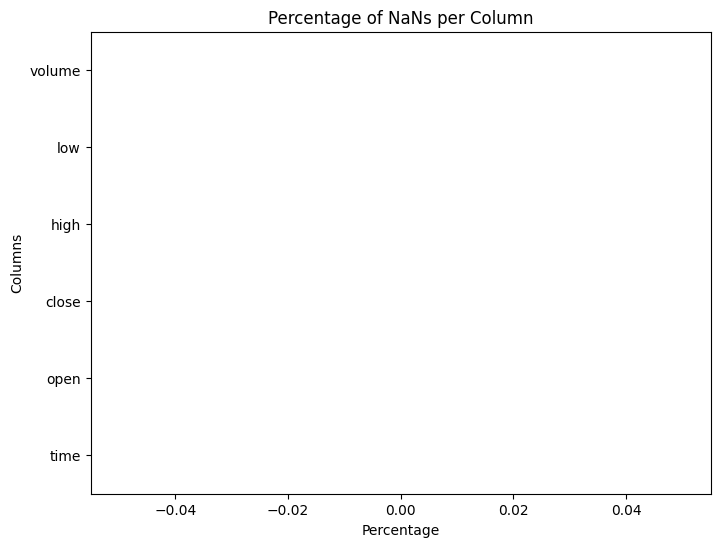

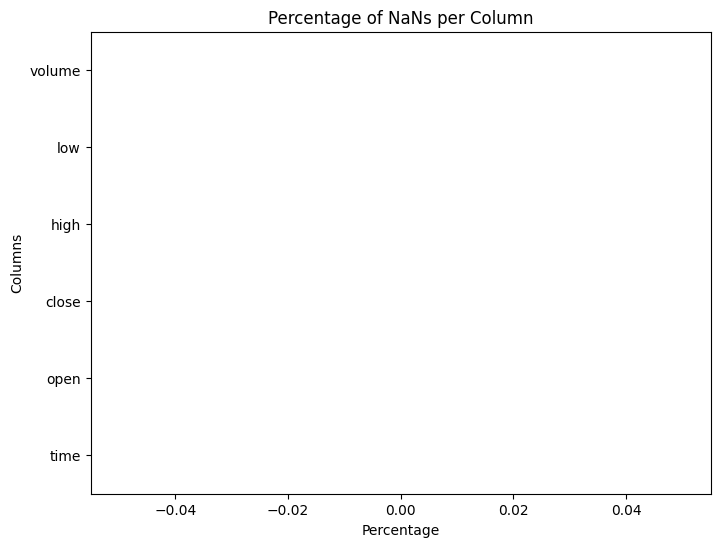

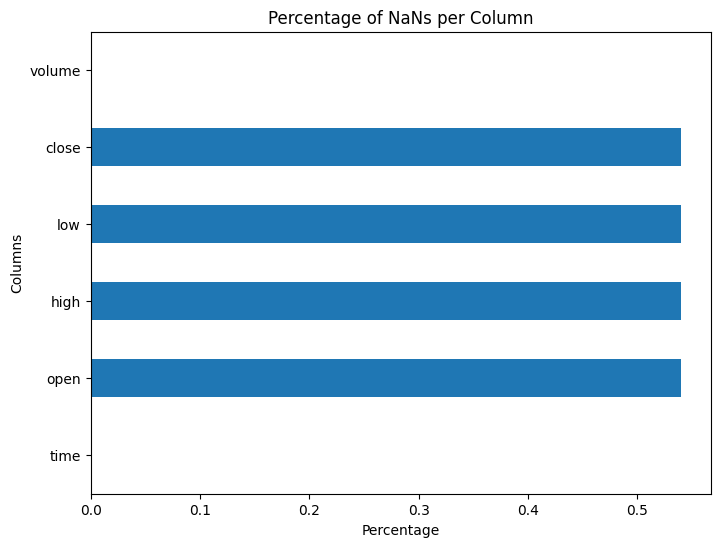

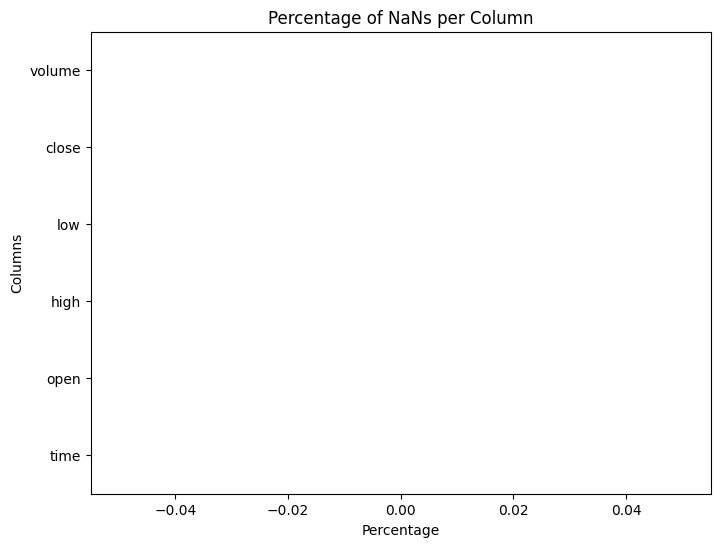

Unique targets in 'target': [ 0 -1  1]
Unique targets in 'target': [1 0 2]


In [ ]:
target_column = 'target'
price_columns = ['log_return', 'high_wick', 'low_wick']
volumn_columns = ['volume']
indicator_columns = [
    'rsi', 'stoch', 'roc', 'macd', 'atr', 'cci', 'dpo', 'kst', 'mass',
     'mfi', 'adx', 'vortex_indicator',
     'parabolic_sar', 'force_index'
]
input_columns = price_columns + volumn_columns + indicator_columns

path = '/content/datasets/solusd.csv'
freq = 'H'
factor = 1

n_past = 48*factor
n_future = 6*factor

short_window=6*factor
medium_window=12*factor
long_window=24*factor

n_classes = 3
thresholds = ([0.02, 0.05], [-0.05, -0.02])

plot_data = True

df, label_mapping = prepare_and_augment_financial_data(
    path, freq, thresholds, n_future, short_window, medium_window, long_window, plot_data=plot_data)


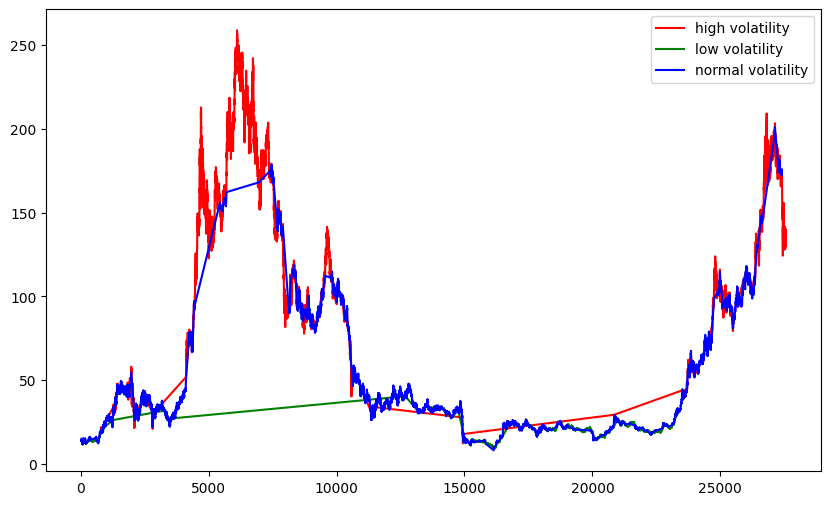

In [ ]:
# Define thresholds based on the 'atr' distribution
high_vol_threshold = df['atr'].quantile(0.75)
low_vol_threshold = df['atr'].quantile(0.25)

# Identify high, normal, and low volatility periods
conditions = [
    (df['atr'] > high_vol_threshold),
    (df['atr'] < low_vol_threshold)
]
choices = ['high', 'low']
df['volatility'] = np.select(conditions, choices, default='normal')

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
colors = {'high': 'red', 'normal': 'blue', 'low': 'green'}
for key, group in df.groupby('volatility'):
    group['close'].plot(ax=ax, label=f'{key} volatility', color=colors[key])
ax.legend()
plt.show()

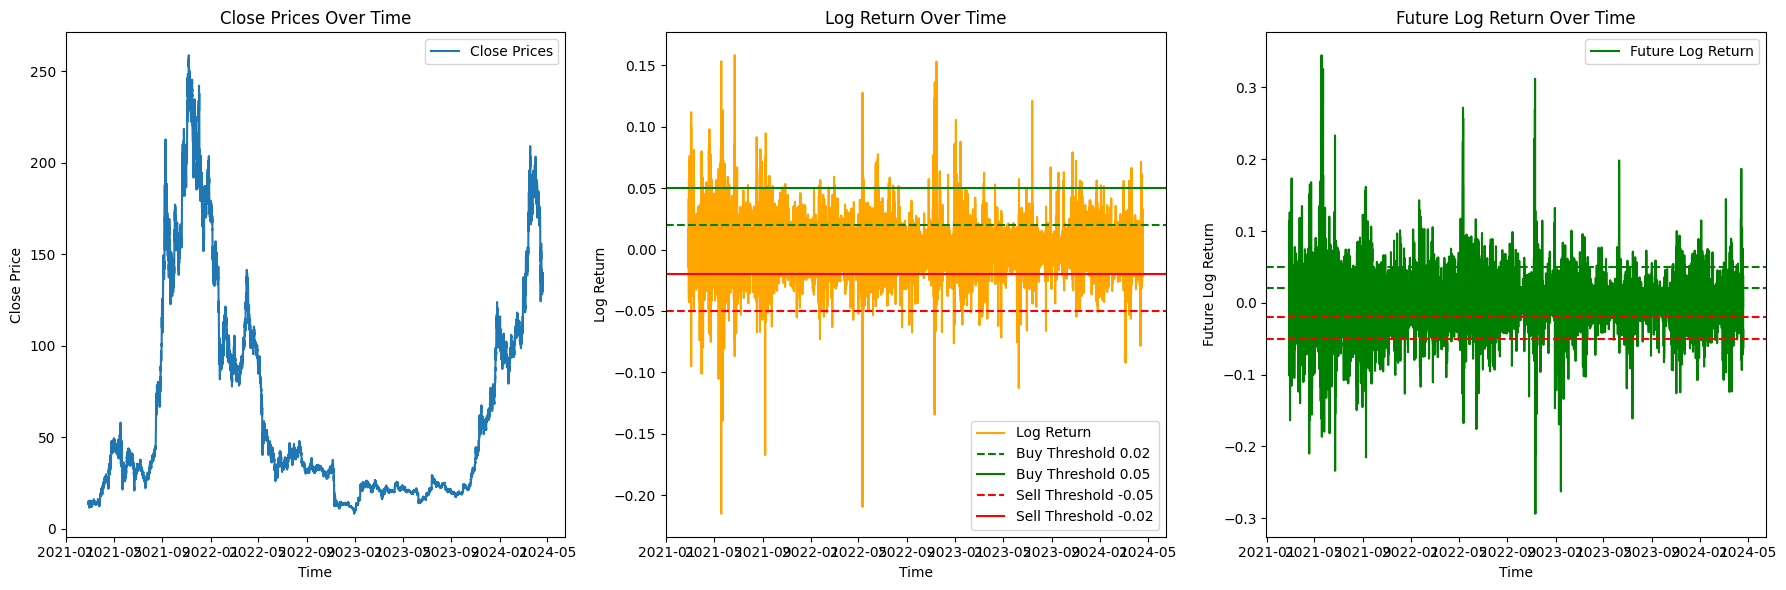

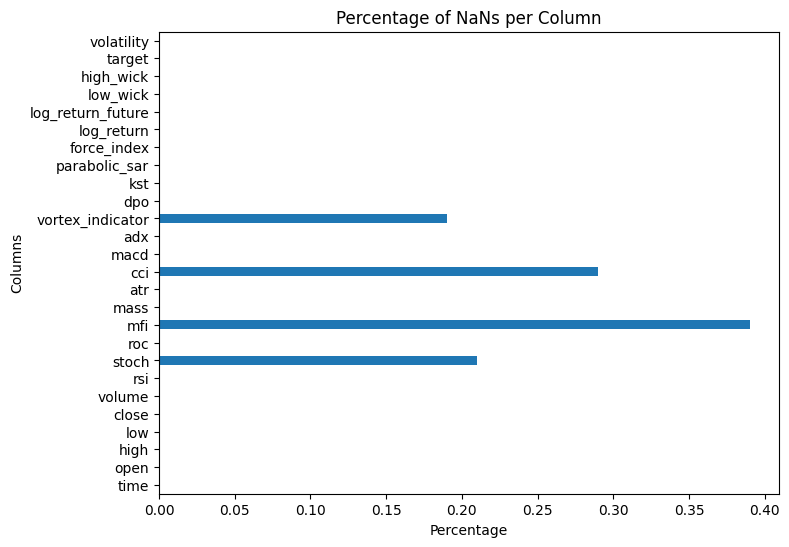

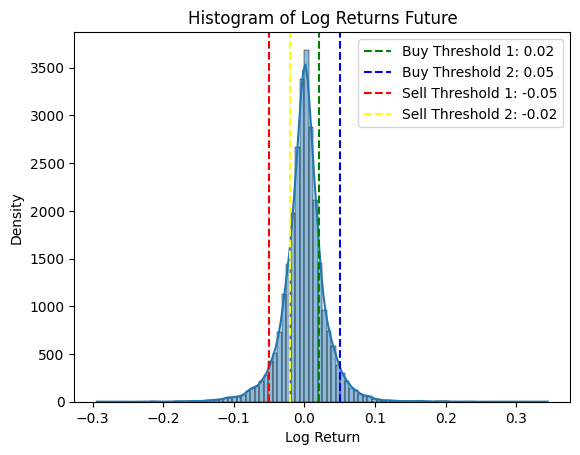

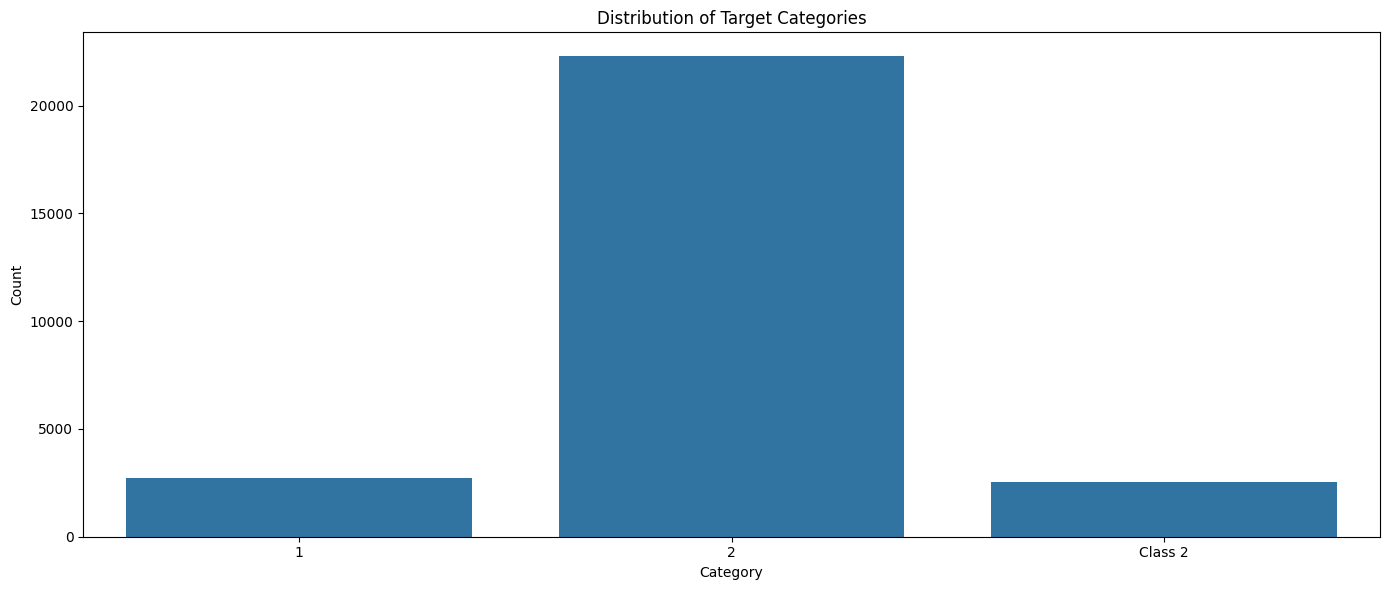

In [ ]:
plot_initial_data(df, plot_data, thresholds, label_mapping)
df = df.drop(columns=['time'])
train_data, test_data = split_data_test_train(df)
train_features, train_targets, test_features, test_targets, preprocessor = apply_preprocessing(
    train_data, test_data, input_columns, price_columns, volumn_columns, indicator_columns)


# Mutiset analysis

In [ ]:
# Paths to your data files
from functools import reduce


target_column = 'target'
price_columns = ['log_return', 'high_wick', 'low_wick']
volumn_columns = ['volume']
indicator_columns = [
    'rsi', 'stoch', 'roc', 'macd', 'cci', 'dpo', 'kst', 'mass',
     'mfi', 'vortex_indicator',
     'parabolic_sar', 'force_index'
]
input_columns = price_columns + volumn_columns + indicator_columns

freq = 'H'
factor = 1

n_past = 48*factor
n_future = 6*factor

short_window=6*factor
medium_window=12*factor
long_window=24*factor

n_classes = 3
thresholds = ([0.012, 0.03], [-0.03, -0.012])

plot_data = True

# Define your data paths and other configurations
data = [
    {'pair': 'solusd', 'csv_path': '/content/datasets/solusd.csv'},
    {'pair': 'ethusd', 'csv_path': '/content/datasets/ethusd.csv'},
    {'pair': 'btcusd', 'csv_path': '/content/datasets/btcusd.csv'}
]

def prefix_columns(df, prefix, ignore_columns=['target', 'time', 'log_return_future']):
    """
    Prefixes all column names in a pandas DataFrame with a specified prefix, except for
    target and time columns if specified.
    """
    # Creating a dictionary to rename columns, skipping the target and time columns if they're in the DataFrame
    new_columns = {
        column: f"{prefix}_{column}" if column not in ignore_columns else column
        for column in df.columns
    }
    df.rename(columns=new_columns, inplace=True)
    return df


# Load and initial preprocess data
dfs = []
for pair in data:
    df = load_and_format_data(pair['csv_path'])
    df = impute_price_columns(df)  # Apply any initial preprocessing
    dfs.append(df)

# Determine the latest start date among all datasets
min_date = max(df['time'].min() for df in dfs)

# Filter all datasets to start from this date
dfs = [df[df['time'] >= min_date] for df in dfs]


price_columns = [f"{pair['pair']}_{col}" for pair in data for col in price_columns]
volumn_columns = [f"{pair['pair']}_{col}" for pair in data for col in volumn_columns]
indicator_columns = [f"{pair['pair']}_{col}" for pair in data for col in indicator_columns]
input_columns = price_columns + volumn_columns + indicator_columns

# Additional processing like resampling, augmenting data, and prefixing columns
label_mapping = None
for i, df in enumerate(dfs):
    df = resample_data(df, 'H')  # Assuming hourly resampling
    df = augment_data(df, thresholds, n_future, short_window, medium_window, long_window)  # Assuming defined elsewhere
    if data[i]['pair'] == 'solusd':
        df, label_mapping = categorize_trading_signals(df, thresholds)
    df = prefix_columns(df, data[i]['pair'])  # Apply unique prefixes based on data pair
    dfs[i] = df  # Store the processed dataframe back in the list

# Merge all dataframes on the 'time' column
final_df = reduce(lambda left, right: pd.merge(left, right, on='time', how='inner'), dfs)
final_df = drop_start(final_df, long_window)

print(final_df.head())

final_df = final_df.drop(columns=['time'])
train_data, test_data = split_data_test_train(final_df)
train_features, train_targets, test_features, test_targets, preprocessor = apply_preprocessing(
    train_data, test_data, input_columns, price_columns, volumn_columns, indicator_columns)


Unique targets in 'target': [ 0  1 -1]
Unique targets in 'target': [1 2 0]
                  time  solusd_open  solusd_high  solusd_low  solusd_close  \
24 2021-02-26 09:00:00       13.521       13.775      13.439        13.775   
25 2021-02-26 10:00:00       13.712       13.995      13.655        13.995   
26 2021-02-26 11:00:00       14.115       14.118      13.667        13.793   
27 2021-02-26 12:00:00       13.812       14.026      13.733        13.997   
28 2021-02-26 13:00:00       14.040       14.043      13.790        13.806   

    solusd_volume  solusd_rsi  solusd_stoch  solusd_roc  solusd_mfi  ...  \
24    2092.813503   43.148402     40.506329   -5.553651   32.677137  ...   
25    1039.477629   51.134786     97.641509   -0.885269   41.177827  ...   
26    3750.782006   44.280941     65.825447    1.561004   36.119381  ...   
27    1562.228673   52.066920     87.276551    3.078283   49.684240  ...   
28    2362.976204   45.001740     55.932203    3.796707   53.501137  ...   


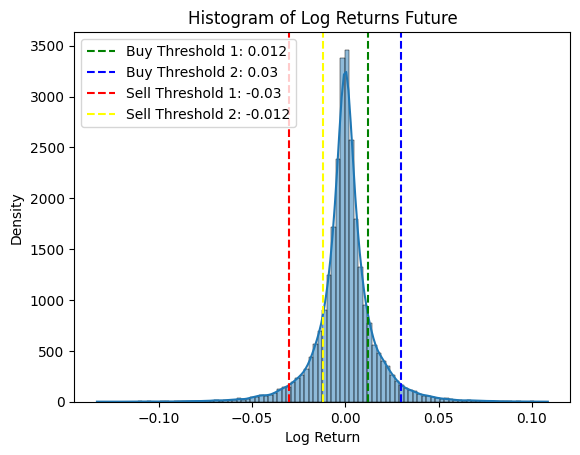

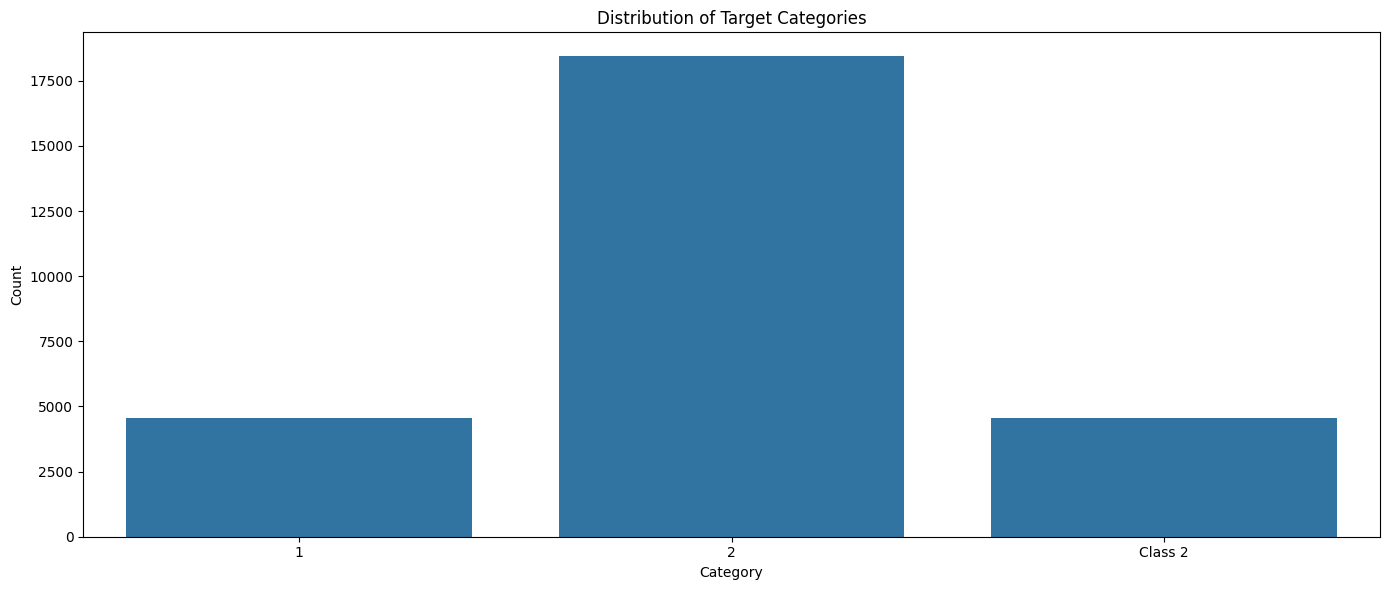

In [ ]:
# plot_final_data(final_df, plot_data, preprocessor, train_features, input_columns)
plot_log_return(final_df, thresholds)
plot_class_distribution(final_df, label_mapping)

# PCA, t-SNE, umap

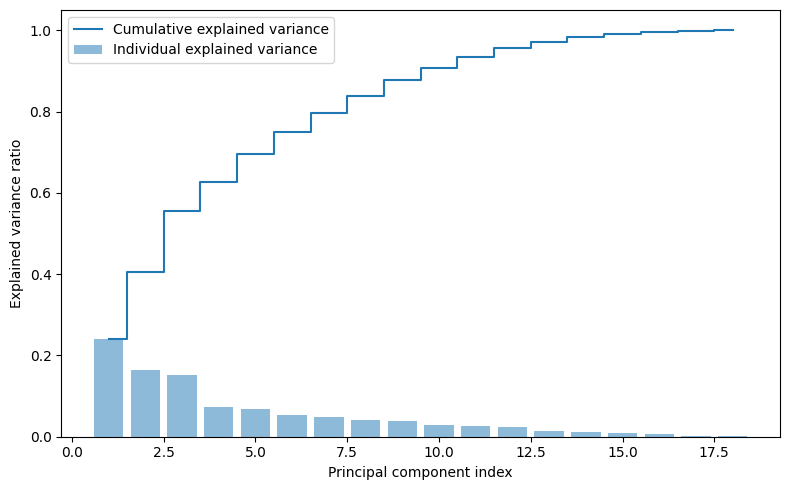

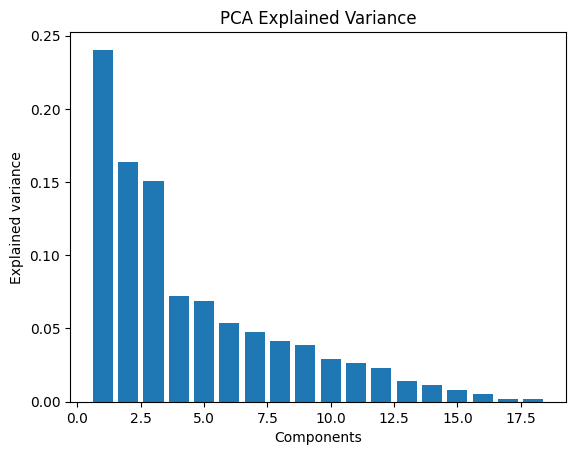

              precision    recall  f1-score   support

           0       0.71      0.33      0.45       504
           1       0.89      0.98      0.93      4695
           2       0.70      0.28      0.40       308

    accuracy                           0.88      5507
   macro avg       0.77      0.53      0.59      5507
weighted avg       0.86      0.88      0.86      5507

[[ 164  340    0]
 [  66 4591   38]
 [   0  221   87]]


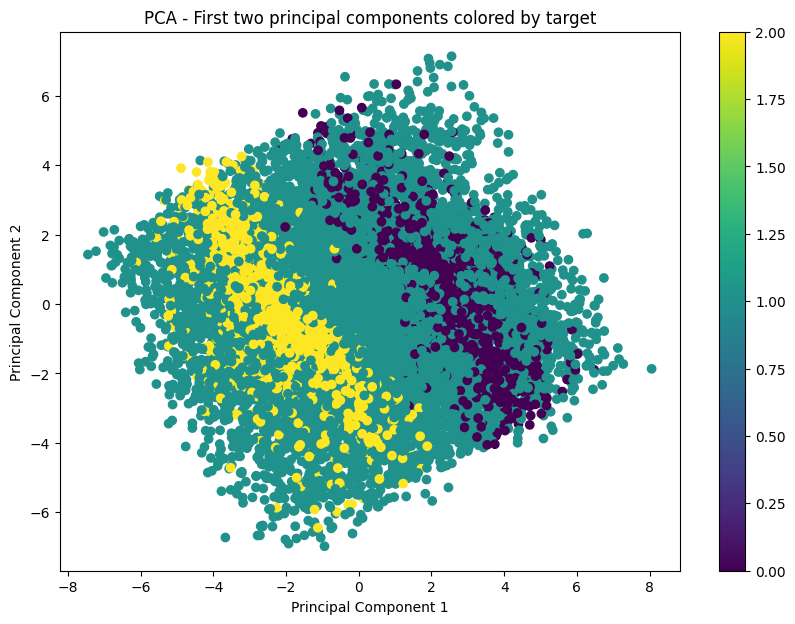

In [ ]:

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


def apply_pca(features, n_components=None):
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(features)
    return principal_components, pca


train_features_pca, pca = apply_pca(train_features, n_components=None)
test_features_pca = pca.transform(test_features)

# Plotting cumulative explained variance
def plot_cumulative_variance(pca):
    plt.figure(figsize=(8,5))
    plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), where='mid', label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component index')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

# Plot cumulative variance
plot_cumulative_variance(pca)

plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.title('PCA Explained Variance')
plt.show()

# Choosing number of components that explain 95% of the variance
total_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_95 = np.where(total_variance >= 0.95)[0][0] + 1  # +1 because index starts at 0
train_features_pca, pca = apply_pca(train_features, n_components=n_components_95)
test_features_pca = pca.transform(test_features)

# Training a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(train_features_pca, train_targets)

# Making predictions
predictions = clf.predict(test_features_pca)

# Evaluating the classifier
print(classification_report(test_targets, predictions))
print(confusion_matrix(test_targets, predictions))

# Plotting the first two principal components
plt.figure(figsize=(10, 7))
plt.scatter(train_features_pca[:, 0], train_features_pca[:, 1], c=train_targets, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - First two principal components colored by target')
plt.colorbar()
plt.show()



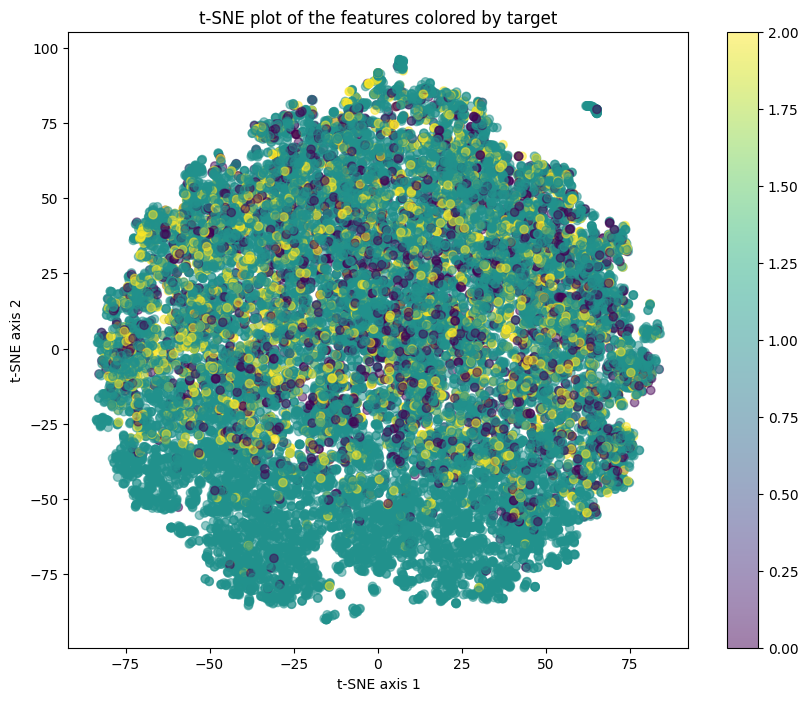

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def apply_tsne(features, n_components=2, perplexity=30, n_iter=1000):
    tsne = TSNE(n_components=n_components, perplexity=perplexity, n_iter=n_iter, random_state=42)
    tsne_results = tsne.fit_transform(features)
    return tsne_results

# Apply t-SNE to the standardized features (before PCA transformation)
tsne_results = apply_tsne(train_features)

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=train_targets, cmap='viridis', alpha=0.5)
plt.colorbar()
plt.title('t-SNE plot of the features colored by target')
plt.xlabel('t-SNE axis 1')
plt.ylabel('t-SNE axis 2')
plt.show()


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


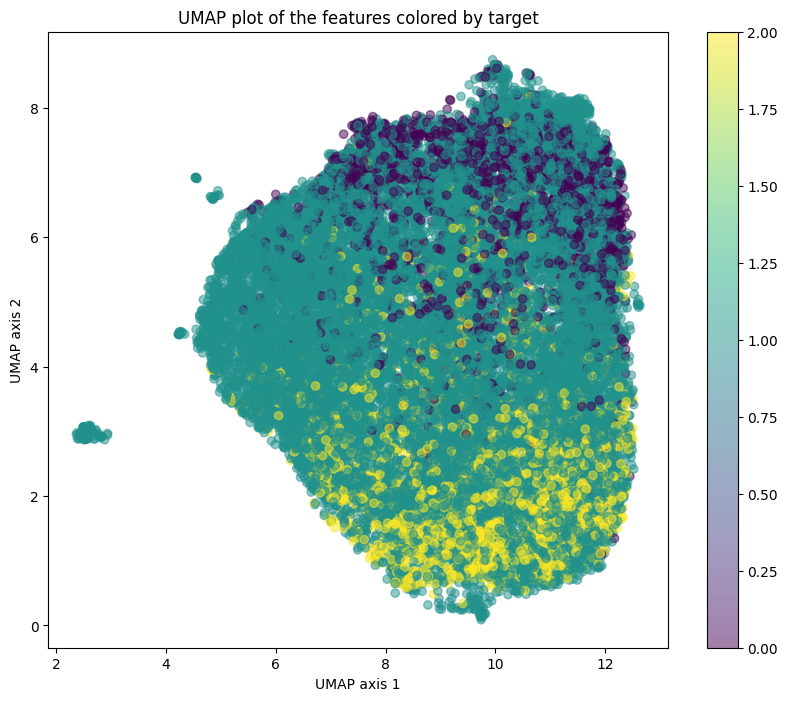

In [ ]:
# !pip install umap-learn
import umap.umap_ as umap

def apply_umap(features, n_neighbors=15, min_dist=0.1, n_components=2):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=42)
    embedding = reducer.fit_transform(features)
    return embedding

# Apply UMAP to the standardized features (before PCA transformation)
umap_results = apply_umap(train_features)

# Plot the UMAP results
plt.figure(figsize=(10, 8))
plt.scatter(umap_results[:, 0], umap_results[:, 1], c=train_targets, cmap='viridis', alpha=0.5)
plt.colorbar()
plt.title('UMAP plot of the features colored by target')
plt.xlabel('UMAP axis 1')
plt.ylabel('UMAP axis 2')
plt.show()


In [ ]:
print(list(final_df.columns))
print(final_df.head(10))

NameError: name 'final_df' is not defined

# Visulization

In [ ]:
import matplotlib.pyplot as plt

def plot_financial_data(df, thresholds):
    buy_thresholds, sell_thresholds = thresholds  # Unpack the tuple into buy and sell thresholds

    plt.figure(figsize=(18, 6))

    # Plotting close prices
    plt.subplot(1, 3, 1)
    plt.plot(df['time'], df['close'], label='Close Prices')
    plt.title('Close Prices Over Time')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()

    # Plotting log returns with dynamic thresholds
    plt.subplot(1, 3, 2)
    plt.plot(df['time'], df['log_return'], label='Log Return', color='orange')
    for idx, threshold in enumerate(buy_thresholds):
        plt.axhline(y=threshold, color='green', linestyle='--' if idx == 0 else '-', label=f'Buy Threshold {threshold}')
    for idx, threshold in enumerate(sell_thresholds):
        plt.axhline(y=threshold, color='red', linestyle='--' if idx == 0 else '-', label=f'Sell Threshold {threshold}')
    plt.title('Log Return Over Time')
    plt.xlabel('Time')
    plt.ylabel('Log Return')
    plt.legend()

    # Plotting future log returns with dynamic thresholds
    plt.subplot(1, 3, 3)
    plt.plot(df['time'], df['log_return_future'], label='Future Log Return', color='green')
    for threshold in buy_thresholds:
        plt.axhline(y=threshold, color='green', linestyle='--')
    for threshold in sell_thresholds:
        plt.axhline(y=threshold, color='red', linestyle='--')
    plt.title('Future Log Return Over Time')
    plt.xlabel('Time')
    plt.ylabel('Future Log Return')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_nan_percentage(df):
    # Calculate the percentage of NaNs per column
    nan_percentage = df.isna().mean().round(4) * 100

    # Plot this information
    plt.figure(figsize=(8, 6))
    nan_percentage.plot(kind='barh')
    plt.title('Percentage of NaNs per Column')
    plt.xlabel('Percentage')
    plt.ylabel('Columns')
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_log_return(df, thresholds):
    buy_thresholds, sell_thresholds = thresholds  # Unpack the tuple into buy and sell thresholds

    sns.histplot(df['log_return_future'], bins=100, kde=True)
    plt.title('Histogram of Log Returns Future')
    plt.xlabel('Log Return')
    plt.ylabel('Density')

    # Plot dynamic buy thresholds
    for idx, threshold in enumerate(buy_thresholds):
        plt.axvline(x=threshold, color='green' if idx == 0 else 'blue', linestyle='--', label=f'Buy Threshold {idx+1}: {threshold}')

    # Plot dynamic sell thresholds
    for idx, threshold in enumerate(sell_thresholds):
        plt.axvline(x=threshold, color='red' if idx == 0 else 'yellow', linestyle='--', label=f'Sell Threshold {idx+1}: {threshold}')

    plt.legend()
    plt.show()


In [ ]:
def plot_class_distribution(df, label_mapping):
    # Count occurrences of each class in the 'target_encoded' column
    class_counts = df['target'].value_counts().sort_index()

    # Use the label mapping to get the original class names based on the encoded values
    class_names = [label_mapping.get(x, f'Class {x}') for x in class_counts.index]

    # Set up the matplotlib figure
    plt.figure(figsize=(14, 6))

    # Bar plot of class distributions using seaborn
    sns.barplot(x=class_names, y=class_counts.values)
    plt.title('Distribution of Target Categories')
    plt.xlabel('Category')
    plt.ylabel('Count')

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_corr_matrix(df, input_columns):
  # Correlation heatmap of features
  plt.figure(figsize=(14, 10))  # Increase figure size
  corr_matrix = df[input_columns].corr()

  # Create a mask to hide the upper triangle of the heatmap
  mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

  # Plot the heatmap
  sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=mask, annot_kws={"size": 8})  # Adjust size of annotations
  plt.title('Correlation Heatmap of Features')
  plt.xticks(rotation=45)  # Rotate x labels
  plt.yticks(rotation=0)  # Ensure y labels are horizontal
  plt.show()



In [ ]:
def plot_data_before_after(df, train_features, transformed_columns):
  # Define number of rows and columns for subplot grid
  n_cols = 4
  n_rows = (len(transformed_columns) + n_cols - 1) // n_cols  # This ensures we have enough rows

  # Define the figure size, width and height per subplot
  subplot_width = 4
  subplot_height = 3
  plt.figure(figsize=(subplot_width * n_cols, subplot_height * n_rows))

  # Plot before scaling
  for i, col in enumerate(transformed_columns):
      plt.subplot(n_rows, n_cols, i + 1)
      sns.histplot(df[col], bins=30, kde=True)
      plt.title(f'{col} (original)')

  plt.tight_layout(pad=2.0)  # Add padding between plots
  plt.show()

  # Plot after scaling
  plt.figure(figsize=(subplot_width * n_cols, subplot_height * n_rows))

  for i, col in enumerate(transformed_columns):
      plt.subplot(n_rows, n_cols, i + 1)
      sns.histplot(train_features[:, i], bins=30, kde=True)
      plt.title(f'{col} (scaled)')

  plt.tight_layout(pad=2.0)  # Add padding between plots
  plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sample_windows(dataset, n_past, n_future, num_samples=3, num_cols=3, label_mapping=None):
    # Calculate the number of rows needed to display the samples
    num_rows = (num_samples + num_cols - 1) // num_cols

    # Create a figure with subplots in a grid
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 3))
    axes = axes.flatten()  # Flatten if the grid is 2D

    # Extract a batch from the dataset
    for features, targets in dataset.take(1):
        features = features.numpy()
        targets = np.argmax(targets.numpy(), axis=1)  # Assuming one-hot encoded targets

        # Randomly sample and plot windows
        for i in range(num_samples):
            idx = np.random.randint(0, len(features))
            axes[i].plot(range(n_past), features[idx], label='Past' if i == 0 else "")
            target_class = label_mapping.get(targets[idx], 'Unknown')  # Get the class name using the mapping
            axes[i].annotate(target_class, (n_past + n_future - 1, features[idx, n_past + n_future - 2]),
                             textcoords="offset points", xytext=(0,10), ha='center', color='red',
                             arrowprops=dict(arrowstyle="->", color='red'))

            axes[i].set_title(f'Window {idx} - {target_class}')

    # Only add the legend to the first subplot to avoid repetition
    axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))  # Adjust the location accordingly

    # Adjust the layout to prevent overlapping
    plt.tight_layout()
    plt.show()



# Train and model def

In [ ]:
from keras.callbacks import Callback
from keras import backend as K

import math

class CyclicLR(Callback):
    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular', gamma=0.99994):
        super(CyclicLR, self).__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

    def clr(self):
        cycle = math.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.mode == 'triangular':
            return self.base_lr + (self.max_lr - self.base_lr) * max(0, (1 - x))
        elif self.mode == 'triangular2':
            return self.base_lr + (self.max_lr - self.base_lr) * max(0, (1 - x)) / float(2**(cycle - 1))
        elif self.mode == 'exp_range':
            return self.base_lr + (self.max_lr - self.base_lr) * max(0, (1 - x)) * (self.gamma**(self.clr_iterations))

    def on_train_begin(self, logs={}):
        K.set_value(self.model.optimizer.lr, self.base_lr)

    def on_batch_end(self, batch, logs={}):
        self.trn_iterations += 1
        self.clr_iterations += 1
        K.set_value(self.model.optimizer.lr, self.clr())
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils.class_weight import compute_class_weight
from keras.utils import to_categorical
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Reshape

def create_lstm(n_past, n_params, n_classes):
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(n_past, n_params)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100))
    model.add(Dropout(0.2))
    model.add(Dense(units=n_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy',
                   metrics=['accuracy', 'Precision', 'Recall'])
    return model

def setup_callbacks():
    early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4)
    cyclic_lr = CyclicLR(base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular')

    return [early_stopping, reduce_lr]

def compute_class_weights(y_train):
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    return dict(enumerate(class_weights))

def split_data_cross_val(data, targets, train_index, test_index, val_ratio=0.1):
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = targets[train_index], targets[test_index]
    val_size = int(len(X_train) * val_ratio)
    X_val, y_val = X_train[-val_size:], y_train[-val_size:]
    X_train, y_train = X_train[:-val_size], y_train[:-val_size]
    return X_train, X_val, X_test, y_train, y_val, y_test

def create_datasets(X_train, y_train, X_val, y_val, X_test, y_test, batch_size):
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(len(X_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(len(X_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return train_dataset, val_dataset, test_dataset

def train_and_evaluate_model(model, train_dataset, val_dataset, epochs, callbacks, class_weights):
    history = model.fit(train_dataset, epochs=epochs, verbose=1, callbacks=callbacks, validation_data=val_dataset, class_weight=class_weights)
    return history

def update_histories(all_histories, history):
    for metric in all_histories.keys():
        all_histories[metric].append(history.history[metric])

def calculate_metrics_and_update_cm(model, test_dataset, cumulative_confusion_matrix):
    y_pred = model.predict(test_dataset)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test = np.concatenate([y for x, y in test_dataset], axis=0)
    y_true_classes = np.argmax(y_test, axis=1)
    f1 = f1_score(y_true_classes, y_pred_classes, average='macro')
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    cumulative_confusion_matrix = cm if cumulative_confusion_matrix is None else cumulative_confusion_matrix + cm
    return f1, cumulative_confusion_matrix


def train_model(lstm_model, batch_size, epochs, n_past, windowed_train_data, windowed_train_targets, label_mapping, plot_results=False):
    callbacks = setup_callbacks()
    all_histories = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': [], 'precision': [], 'val_precision': [], 'recall': [], 'val_recall': []}
    cumulative_confusion_matrix = None
    tscv = TimeSeriesSplit(n_splits=5)

    for fold, (train_index, test_index) in enumerate(tscv.split(windowed_train_data)):
        X_train, X_val, X_test, y_train, y_val, y_test = split_data_cross_val(windowed_train_data, windowed_train_targets, train_index, test_index)
        class_weights = compute_class_weights(y_train)
        y_train, y_val, y_test = map(to_categorical, [y_train, y_val, y_test])
        train_dataset, val_dataset, test_dataset = create_datasets(X_train, y_train, X_val, y_val, X_test, y_test, batch_size)
        history = train_and_evaluate_model(lstm_model, train_dataset, val_dataset, epochs, callbacks, class_weights)
        update_histories(all_histories, history)
        f1, cumulative_confusion_matrix = calculate_metrics_and_update_cm(lstm_model, test_dataset, cumulative_confusion_matrix)
        print(f'F1 Score for fold {fold}: {f1}')

    if plot_results:
        plot_train_results(all_histories, cumulative_confusion_matrix, label_mapping)

    return lstm_model, all_histories, cumulative_confusion_matrix


In [ ]:

def plot_train_results(all_histories, cumulative_confusion_matrix, label_mapping):
    # Calculate the mean of the metric across folds for each epoch
    max_epochs = max(max(len(hist) for hist in all_histories[metric]) for metric in all_histories)

    # Function to pad histories to the same length
    def pad_history(hist, target_length, padding_value='last'):
        if padding_value == 'last':
            padding_value = hist[-1]
        return np.concatenate([hist, np.full((target_length - len(hist)), padding_value)])

    # Pad each metric history in all_histories and calculate the mean across folds
    mean_histories = {
        metric: np.mean(
            np.vstack([pad_history(hist, max_epochs) for hist in all_histories[metric]]), axis=0
        ) for metric in all_histories
    }
    num_classes = 3

    # Plotting the mean metrics across folds
    plt.figure(figsize=(14, 4))

    # Plot mean training & validation accuracy values
    plt.subplot(1, 3, 1)
    plt.plot(mean_histories['accuracy'])
    plt.plot(mean_histories['val_accuracy'])
    plt.title('Average Model Accuracy across Folds')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

    # Plot mean training & validation loss values
    plt.subplot(1, 3, 2)
    plt.plot(mean_histories['loss'])
    plt.plot(mean_histories['val_loss'])
    plt.title('Average Model Loss across Folds')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

    # Plot mean training & validation precision values
    plt.subplot(1, 3, 3)
    plt.plot(mean_histories['precision'])
    plt.plot(mean_histories['val_precision'])
    plt.title('Average Model Precision across Folds')
    plt.ylabel('Precision')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

    # Plot the cumulative confusion matrix if it's not None
    if cumulative_confusion_matrix is not None:
        plt.figure(figsize=(8, 6))
        class_labels = [label for label, index in sorted(label_mapping.items(), key=lambda item: item[1])]
        sns.heatmap(cumulative_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
        plt.title('Cumulative Confusion Matrix across All Folds')
        plt.xlabel('Predicted')
        plt.ylabel('True')

        plt.tight_layout()
        plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def test_holdoutset(lstm_model, windowed_test_data, windowed_test_targets, label_mapping, plot_results=False):

    # Predict on the windowed test data
    test_predictions_proba = lstm_model.predict(windowed_test_data)

    # Convert the probabilities to class predictions
    test_predictions = np.argmax(test_predictions_proba, axis=1)

    # Print shapes to ensure they are both 1D and of the same length
    print("Shape of windowed_test_targets:", windowed_test_targets.shape)
    print("Shape of test_predictions:", test_predictions.shape)

    # Now you have your predictions and true labels as flat arrays, you can calculate the metrics
    accuracy = accuracy_score(windowed_test_targets, test_predictions)
    precision = precision_score(windowed_test_targets, test_predictions, average='weighted', zero_division=0)
    recall = recall_score(windowed_test_targets, test_predictions, average='weighted', zero_division=0)
    f1 = f1_score(windowed_test_targets, test_predictions, average='weighted', zero_division=0)

    # Print the calculated metrics
    print(f'Accuracy on hold-out test set: {accuracy:.2f}')
    print(f'Precision on hold-out test set: {precision:.2f}')
    print(f'Recall on hold-out test set: {recall:.2f}')
    print(f'F1 Score on hold-out test set: {f1:.2f}')

    # Get a full classification report
    print("\nClassification Report:")
    print(classification_report(windowed_test_targets, test_predictions, zero_division=0))

    if plot_results:
        # Create labels for the confusion matrix
        class_labels = [label for label, index in sorted(label_mapping.items(), key=lambda item: item[1])]

        # Compute confusion matrix
        confusion_mat = confusion_matrix(windowed_test_targets, test_predictions)

        # Plot the confusion matrix
        plt.figure(figsize=(10, 7))
        sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()


    return test_predictions

# Simulation

In [ ]:
def grid_search_simulate_trades(df, predictions, prices, allow_shorting=True):


    # Parameters for the simulation
    initial_capital = 100000  # starting capital
    transaction_cost_percentage = 0.0025  # for example, a 0.1% transaction cost
    risk_capital_percentage = 1

    # Define the range for take-profit and stop-loss percentages
    tp_range = np.arange(0.03, 0.10, 0.005)  # from 0.5% to 7.5%
    sl_range = np.arange(0.02, 0.06, 0.005)  # from 0.5% to 7.5%

    best_parameters = {}
    highest_capital = 0

    # Grid search over the range of take-profit and stop-loss percentages
    for tp in tp_range:
        for sl in sl_range:
            success_rate, final_capital, _, _, _ = simulate_trades(
                predictions,
                prices,
                initial_capital,
                transaction_cost_percentage,
                tp,
                sl,
                risk_capital_percentage,
                allow_shorting=allow_shorting
            )

            # Update the best parameters if the current capital is higher than previously recorded
            if final_capital > highest_capital:
                highest_capital = final_capital
                best_parameters = {'take_profit': tp, 'stop_loss': sl, 'final_capital': final_capital}

    # Run the simulation with best params
    success_rate, final_capital, capital_over_time, entry_points, exit_points = simulate_trades(
        predictions,
        prices,
        initial_capital,
        transaction_cost_percentage,
        best_parameters['take_profit'],
        best_parameters['stop_loss'],
        risk_capital_percentage,
        allow_shorting=allow_shorting
    )

    return best_parameters, success_rate, final_capital, capital_over_time, entry_points, exit_points


In [ ]:
# Taking in the ability for short positions
def simulate_trades(predictions, prices, initial_capital, transaction_cost_percentage, take_profit_percentage, stop_loss_percentage, risk_capital_percentage, allow_shorting=True):
    capital = initial_capital
    capital_over_time = [capital]  # List to track capital over time
    position = 0  # Positive for long, negative for short
    entry_price = 0
    successful_trades = 0
    total_trades = 0
    entry_points = []  # For plotting entry signals
    exit_points = []   # For plotting exit signals

    for i in range(len(predictions)):
        current_price = prices[i]

        # Check for take-profit or stop-loss if there is an open position
        if position != 0:

            if position > 0:  # Long position
                profit_target = entry_price * (1 + take_profit_percentage)
                loss_target = entry_price * (1 - stop_loss_percentage)
                if (current_price <= loss_target or current_price >= profit_target):
                    exit_points.append(('long', i, current_price))  # Record the exit point as long

                    # Calculate the value of the current position
                    position_value = position * current_price
                    # Calculate transaction costs
                    cost = position_value * transaction_cost_percentage
                    # Update capital with the profit (or loss) from the trade
                    capital += position_value - cost
                    # Reset position
                    position = 0
                    # Increase successful_trades if there was a profit
                    if current_price > entry_price:
                        successful_trades += 1


            else:  # Short position
                profit_target = entry_price * (1 - take_profit_percentage)
                loss_target = entry_price * (1 + stop_loss_percentage)

                if (current_price >= loss_target or current_price <= profit_target):
                    exit_points.append(('short', i, current_price))  # Record the exit point as short

                    position_value = abs(position) * current_price
                    entry_value = abs(position) * entry_price
                    profit_or_loss = entry_value - position_value
                    cost = position_value * transaction_cost_percentage
                    capital += entry_value + profit_or_loss - cost
                    position = 0
                    if current_price < entry_price:
                        successful_trades += 1



        # Execute buy orders for long positions
        if predictions[i] == 'buy' and position == 0:
            total_trades += 1
            entry_points.append(('long', i, current_price))  # Record the entry point as long

            # Calculate the amount of capital to risk on the trade
            trade_risk_capital = capital * risk_capital_percentage
            # Calculate transaction costs
            cost = trade_risk_capital * transaction_cost_percentage
            # Calculate the new position size for a long position
            position = (trade_risk_capital - cost) / current_price
            # Update capital by subtracting the risked capital
            capital -= trade_risk_capital
            entry_price = current_price

        # Execute sell orders for short positions
        if allow_shorting and predictions[i] == 'sell' and position == 0:
            total_trades += 1
            entry_points.append(('short', i, current_price))  # Record the entry point as short

            # Calculate the amount of capital to risk on the trade
            trade_risk_capital = capital * risk_capital_percentage
            # Calculate transaction costs
            cost = trade_risk_capital * transaction_cost_percentage
            # Calculate the new position size for a short position (negative)
            position = -(trade_risk_capital - cost) / current_price
            # Update capital by subtracting the risked capital
            capital -= trade_risk_capital
            entry_price = current_price

        # Capital valuation for open positions
        if position > 0:  # Long position valuation
            position_value = position * current_price
            capital_valuation = capital + position_value
        elif position < 0:  # Short position valuation
            position_value = abs(position) * (2 * entry_price - current_price)  # This reflects the 'paper profit'
            capital_valuation = capital + position_value
        else:
            capital_valuation = capital

        capital_over_time.append(capital_valuation)

    # Final capital calculation
    final_capital = capital_over_time[-1]

    # Calculate success rate
    success_rate = successful_trades / total_trades if total_trades > 0 else 0

    return success_rate, final_capital, capital_over_time, entry_points, exit_points

def has_consecutive_elements_at_index(predictions, element, n, start_index):
    # Check if the start_index and start_index + n are within the bounds of the list
    if start_index < 0 or start_index + n > len(predictions):
        return False  # Out of bounds
    # Check if the slice from start_index to start_index + n matches the target sequence
    return predictions[start_index:start_index + n] == [element] * n


In [ ]:
def plot_simulation_results(prices, best_parameters, success_rate, final_capital, capital_over_time, entry_points, exit_points, plot_zoom=False):
    # Separate the entry points by type
    long_entries = [(index, price) for pos_type, index, price in entry_points if pos_type == 'long']
    short_entries = [(index, price) for pos_type, index, price in entry_points if pos_type == 'short']
    # For exit points, just get the index and price
    exit_indices = [index for pos_type, index, price in exit_points]
    exit_prices = [price for pos_type, index, price in exit_points]

    # Now you can plot using different markers for long and short
    plt.figure(figsize=(18, 8))

    # Capital over time in the first subplot
    plt.subplot(1, 2, 1)
    plt.plot(capital_over_time, label='Capital Over Time')
    plt.title('Capital Over Time')
    plt.xlabel('Trade Number')
    plt.ylabel('Capital')
    plt.legend()

    # Entry and exit points in the second subplot
    plt.subplot(1, 2, 2)
    plt.plot(prices, label='Price', color='gray', alpha=0.5)
    if long_entries:
        plt.scatter(*zip(*long_entries), color='green', label='Long Entry', marker='^', alpha=0.7)
    if short_entries:
        plt.scatter(*zip(*short_entries), color='red', label='Short Entry', marker='v', alpha=0.7)
    plt.scatter(exit_indices, exit_prices, color='blue', label='Exit', marker='D', alpha=0.7)

    plt.title('Entry and Exit Points')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()
    plt.show()

    if plot_zoom:
      # Define the range you want to zoom in on
      start_index = 2005  # Update this to your desired starting index
      end_index = 2015  # Update this to your desired ending index

      # Filter the entry and exit points for the defined range and separate them by type
      filtered_long_entries = [(index, price) for pos_type, index, price in entry_points if pos_type == 'long' and start_index <= index <= end_index]
      filtered_short_entries = [(index, price) for pos_type, index, price in entry_points if pos_type == 'short' and start_index <= index <= end_index]
      filtered_exit_points = [(index, price) for pos_type, index, price in exit_points if start_index <= index <= end_index]

      # Extract the indices and prices for the zoomed-in entry and exit points
      long_entry_indices, long_entry_prices = zip(*filtered_long_entries) if filtered_long_entries else ([], [])
      short_entry_indices, short_entry_prices = zip(*filtered_short_entries) if filtered_short_entries else ([], [])
      exit_indices, exit_prices = zip(*filtered_exit_points) if filtered_exit_points else ([], [])

      # Create a new figure for the zoomed-in plots
      plt.figure(figsize=(18, 8))

      # Plot the capital over time zoomed in
      plt.subplot(1, 2, 1)
      zoomed_capital_over_time = capital_over_time[start_index:end_index]
      plt.plot(range(start_index, end_index), zoomed_capital_over_time, label='Capital Over Time')
      plt.title('Capital Over Time (Zoomed In)')
      plt.xlabel('Trade Number')
      plt.ylabel('Capital')
      plt.legend()

      # Plot the price series and the entry/exit points zoomed in
      plt.subplot(1, 2, 2)
      zoomed_actual_prices = prices[start_index:end_index]
      plt.plot(range(start_index, end_index), zoomed_actual_prices, label='Price', color='gray', alpha=0.5)

      # Plot the long entries with green up arrows and short entries with red down arrows
      plt.scatter(long_entry_indices, long_entry_prices, color='green', label='Long Entry', marker='^', alpha=0.7)

      plt.scatter(short_entry_indices, short_entry_prices, color='red', label='Short Entry', marker='v', alpha=0.7)
      # Plot exits with blue diamonds
      plt.scatter(exit_indices, exit_prices, color='blue', label='Exit Point', marker='D', alpha=0.7)

      plt.title('Entry and Exit Points (Zoomed In)')
      plt.xlabel('Time')
      plt.ylabel('Price')
      plt.legend()

      plt.tight_layout()
      plt.show()

    print(f"Best parameters: Take-Profit: {best_parameters['take_profit']*100:.2f}%, Stop-Loss: {best_parameters['stop_loss']*100:.2f}%")
    print(f"Success rate: {success_rate * 100:.2f}%")
    print(f"Final capital: ${final_capital:.2f}")

# Evaluate

Epoch 1/10
52/52 [==============================] - 8s 42ms/step - loss: 1.0122 - accuracy: 0.3772 - precision: 0.8333 - recall: 0.2047 - val_loss: 1.0843 - val_accuracy: 0.3388 - val_precision: 0.5080 - val_recall: 0.2596 - lr: 0.0010
Epoch 2/10
52/52 [==============================] - 1s 16ms/step - loss: 0.8885 - accuracy: 0.4527 - precision: 0.6079 - recall: 0.3220 - val_loss: 0.8931 - val_accuracy: 0.3989 - val_precision: 0.5354 - val_recall: 0.3306 - lr: 0.0010
Epoch 3/10
52/52 [==============================] - 1s 16ms/step - loss: 0.6085 - accuracy: 0.5570 - precision: 0.5694 - recall: 0.4539 - val_loss: 0.6983 - val_accuracy: 0.6803 - val_precision: 0.6777 - val_recall: 0.6148 - lr: 0.0010
Epoch 4/10
52/52 [==============================] - 1s 16ms/step - loss: 0.5195 - accuracy: 0.6349 - precision: 0.6372 - recall: 0.5916 - val_loss: 0.8635 - val_accuracy: 0.5874 - val_precision: 0.5826 - val_recall: 0.5683 - lr: 0.0010
Epoch 5/10
52/52 [==============================] - 1s 1

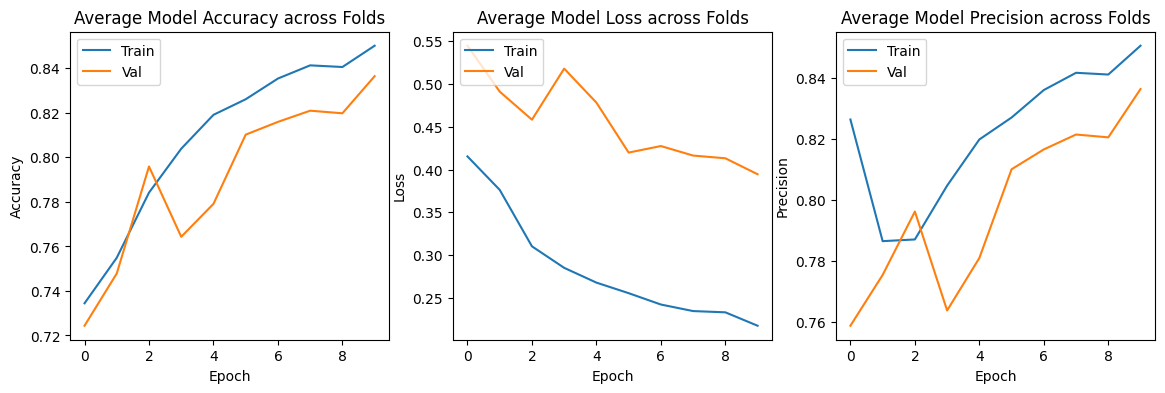

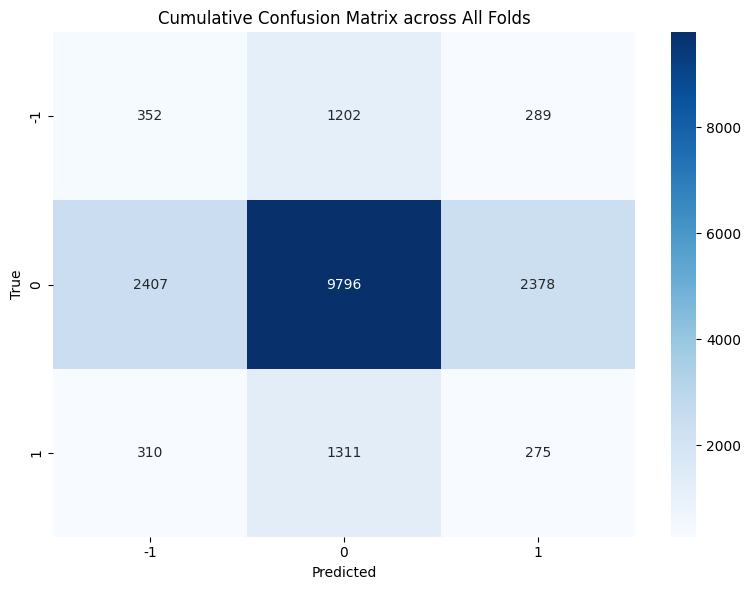

171/171 [==============================] - 2s 6ms/step
Shape of windowed_test_targets: (5459,)
Shape of test_predictions: (5459,)
Accuracy on hold-out test set: 0.89
Precision on hold-out test set: 0.91
Recall on hold-out test set: 0.89
F1 Score on hold-out test set: 0.90

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.88      0.74       504
           1       0.97      0.90      0.94      4647
           2       0.55      0.76      0.64       308

    accuracy                           0.89      5459
   macro avg       0.72      0.85      0.77      5459
weighted avg       0.91      0.89      0.90      5459



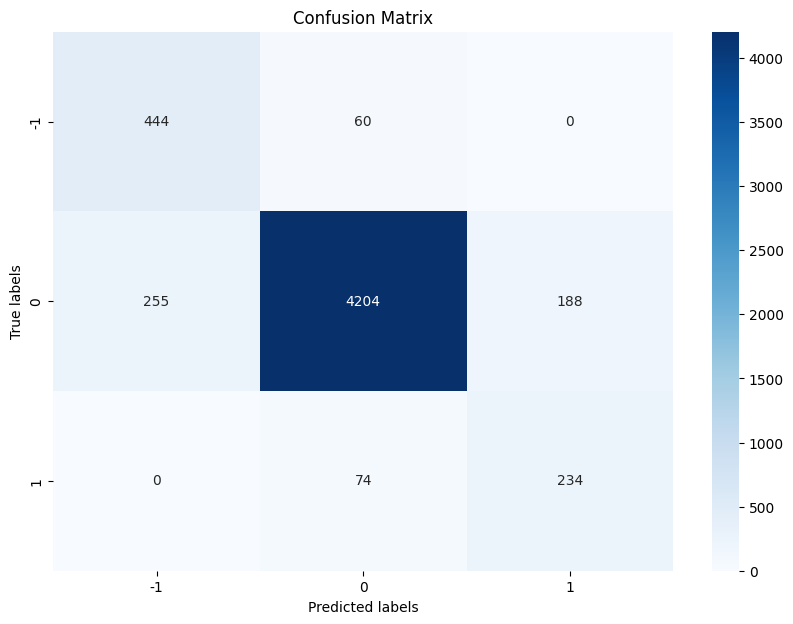

In [ ]:
batch_size = 64
epochs = 10
plot_results = True

windowed_train_data, windowed_train_targets, windowed_test_data, windowed_test_targets = create_model_windows(
    train_features_pca, train_targets, test_features_pca, test_targets, n_past)

n_features = n_components_95

lstm_model = create_lstm(n_past, n_features, n_classes)
lstm_model, all_histories, cumulative_confusion_matrix = train_model(
    lstm_model,
    batch_size,
    epochs,
    n_past,
    windowed_train_data,
    windowed_train_targets,
    label_mapping,
    plot_results=plot_results
)

test_predictions = test_holdoutset(
    lstm_model,
    windowed_test_data,
    windowed_test_targets,
    label_mapping,
    plot_results=plot_results
)

Average Success Rate: 0.43283582089552236
Average Final Capital: 153266.35333199802
Average Stop Loss: 0.05
Average Take Profit: 0.09999999999999996


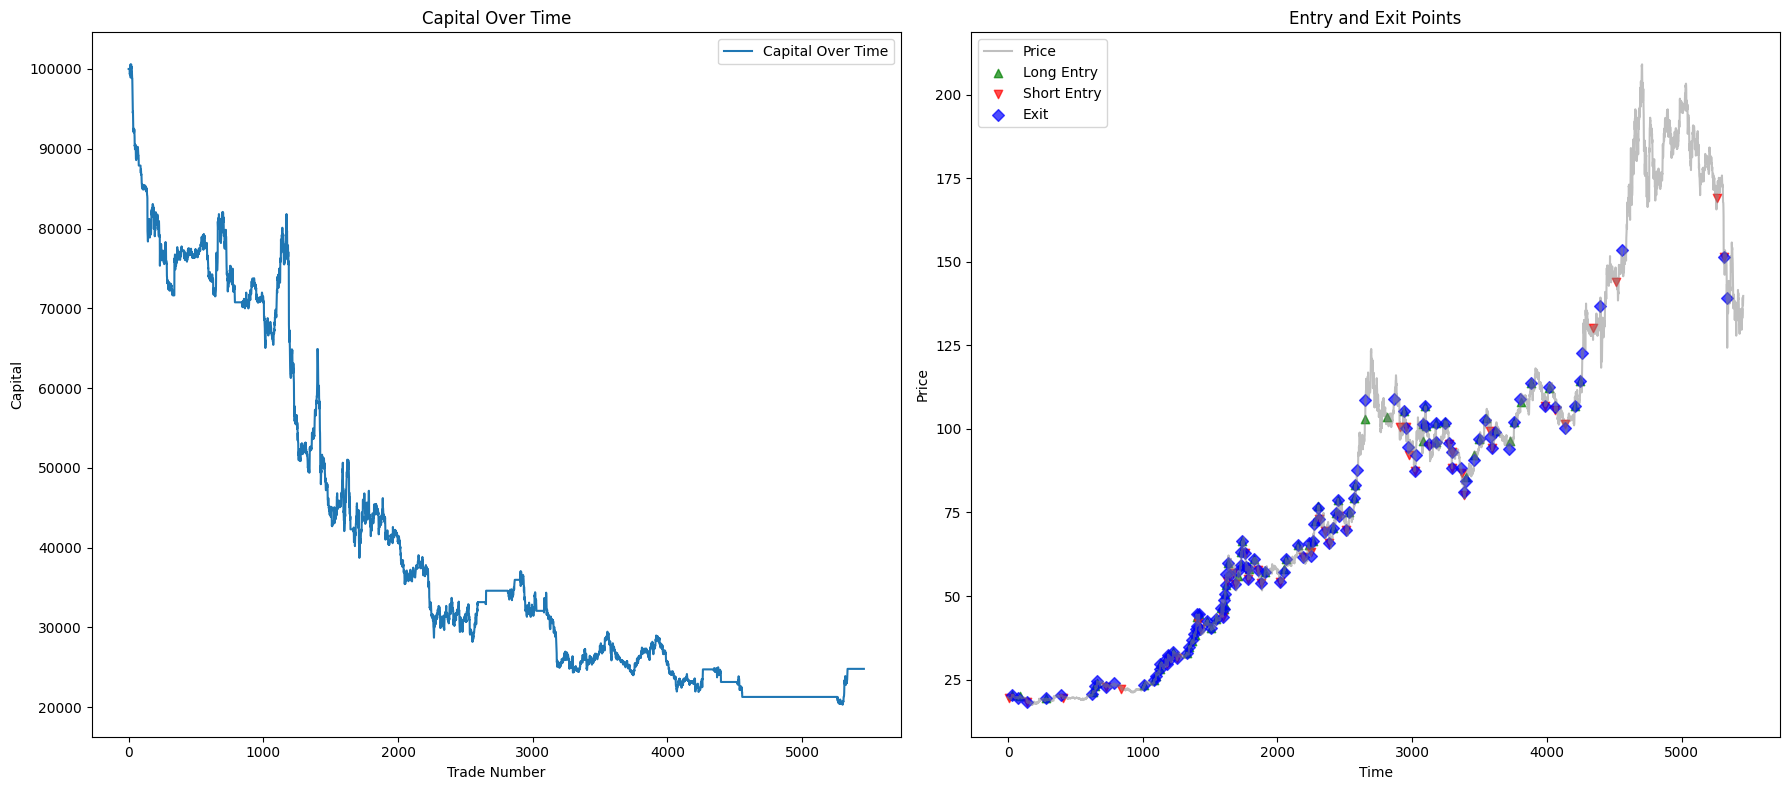

Best parameters: Take-Profit: 5.00%, Stop-Loss: 3.00%
Success rate: 51.69%
Final capital: $24807.55


In [ ]:
import numpy as np

# Invert the label mapping
inv_label_mapping = {v: k for k, v in label_mapping.items()}

# Map the test_predictions back to their original labels
original_labels = [inv_label_mapping[pred] for pred in test_predictions]

# Define a function to transform original integer labels to trading actions
def label_to_action(label):
    if label == 0:
        return 'hold'
    elif label == -1:
        return f'buy'
    else:
        return f'sell'

# Transform labels to actions
predictions = [label_to_action(label) for label in original_labels]

# df = final_df
# prices = df['solusd_close'].values[-len(predictions):]


prices = df['close'].values[-len(predictions):]

# Splitting the predictions and prices into 4 parts
num_parts = 1
predictions_parts = np.array_split(predictions, num_parts)
prices_parts = np.array_split(prices, num_parts)
allow_shorting=True

success_rates = []
final_capitals = []
stop_losses = []
take_profits = []

# Run the simulation for each part
for i in range(num_parts):
    best_params, sr, fc, cot, ep, xp = grid_search_simulate_trades(df, predictions_parts[i], prices_parts[i], allow_shorting=allow_shorting)

    success_rates.append(sr)
    final_capitals.append(fc)

    # Assuming 'best_params' includes 'stop_loss' and 'take_profit' keys
    stop_losses.append(best_params['stop_loss'])
    take_profits.append(best_params['take_profit'])

    # plot_simulation_results(prices_parts[i], best_params, sr, fc, cot, ep, xp)

# Calculating averages
average_success_rate = np.mean(success_rates)
average_final_capital = np.mean(final_capitals)
average_stop_loss = np.mean(stop_losses)
average_take_profit = np.mean(take_profits)

print(f"Average Success Rate: {average_success_rate}")
print(f"Average Final Capital: {average_final_capital}")
print(f"Average Stop Loss: {average_stop_loss}")
print(f"Average Take Profit: {average_take_profit}")

initial_capital = 100000
transaction_cost_percentage = 0.0064
risk_capital_percentage = 1
take_profit = 0.05
stop_loss = 0.03

success_rate, final_capital, capital_over_time, entry_points, exit_points = simulate_trades(
    predictions,
    prices,
    initial_capital,
    transaction_cost_percentage,
    take_profit,
    average_stop_loss,
    risk_capital_percentage,
    allow_shorting=allow_shorting
                )

best_params = {'take_profit': take_profit,
               'stop_loss': stop_loss,
               'final_capital': final_capital
               }
plot_simulation_results(prices, best_params, success_rate, final_capital, capital_over_time, entry_points, exit_points)



In [ ]:
# Load and preprocess data
path = '/content/datasets/solusd.csv'
# path = '/content/drive/MyDrive/datasets/datasets/solusd.csv'

freq = '60min'
plot_data = False

n_past = 48
n_future = 6

# Bounds to filter noise
buy_thresholds = [0.04, 0.105]
sell_thresholds = [-0.105, -0.04]

epochs = 20
batch_size = 32

plot_data = False
plot_results = True

In [ ]:

paths = ['/content/datasets/btcusd.csv',
         '/content/datasets/ethusd.csv',
         '/content/datasets/solusd.csv'
         ]
path = '/content/datasets/solusd.csv'
# path = '/content/drive/MyDrive/datasets/datasets/solusd.csv'

freq = 'H'
factor = 1

n_past = 48*factor
n_future = 6*factor

short_window=6*factor
medium_window=12*factor
long_window=24*factor

n_classes = 3
thresholds = ([0.03, 0.06], [-0.06, -0.03])

epochs = 25
batch_size = 64

plot_data = True
plot_results = True

df, windowed_train_data, windowed_train_targets, windowed_test_data, windowed_test_targets, label_mapping = preprocess_data(
    path,
    freq,
    n_past,
    n_future,
    thresholds,
    INPUT_COLUMNS,
    short_window=short_window,
    medium_window=medium_window,
    long_window=long_window,
    plot_data=plot_data
)

lstm_model = create_lstm(n_past, len(INPUT_COLUMNS), n_classes)
lstm_model, all_histories, cumulative_confusion_matrix = train_model(
    lstm_model,
    batch_size,
    epochs,
    n_past,
    windowed_train_data,
    windowed_train_targets,
    label_mapping,
    plot_results=plot_results
)

test_predictions = test_holdoutset(
    lstm_model,
    windowed_test_data,
    windowed_test_targets,
    label_mapping,
    plot_results=plot_results
)


TypeError: preprocess_data() missing 3 required positional arguments: 'price_columns', 'volumn_columns', and 'indicator_columns'

Epoch 1/25
52/52 [==============================] - 15s 45ms/step - loss: 1.0815 - accuracy: 0.3581 - precision: 0.2242 - recall: 0.0112 - val_loss: 1.0976 - val_accuracy: 0.2760 - val_precision: 0.5000 - val_recall: 0.0055 - lr: 0.0010
Epoch 2/25
52/52 [==============================] - 1s 18ms/step - loss: 0.9944 - accuracy: 0.3354 - precision: 0.3140 - recall: 0.1019 - val_loss: 0.9818 - val_accuracy: 0.4563 - val_precision: 0.3083 - val_recall: 0.1120 - lr: 0.0010
Epoch 3/25
52/52 [==============================] - 1s 17ms/step - loss: 0.8024 - accuracy: 0.4233 - precision: 0.3813 - recall: 0.2580 - val_loss: 0.9269 - val_accuracy: 0.4645 - val_precision: 0.4088 - val_recall: 0.3306 - lr: 0.0010
Epoch 4/25
52/52 [==============================] - 1s 17ms/step - loss: 0.6868 - accuracy: 0.4536 - precision: 0.4395 - recall: 0.3899 - val_loss: 0.9968 - val_accuracy: 0.4317 - val_precision: 0.3783 - val_recall: 0.3142 - lr: 0.0010
Epoch 5/25
52/52 [==============================] - 1s 

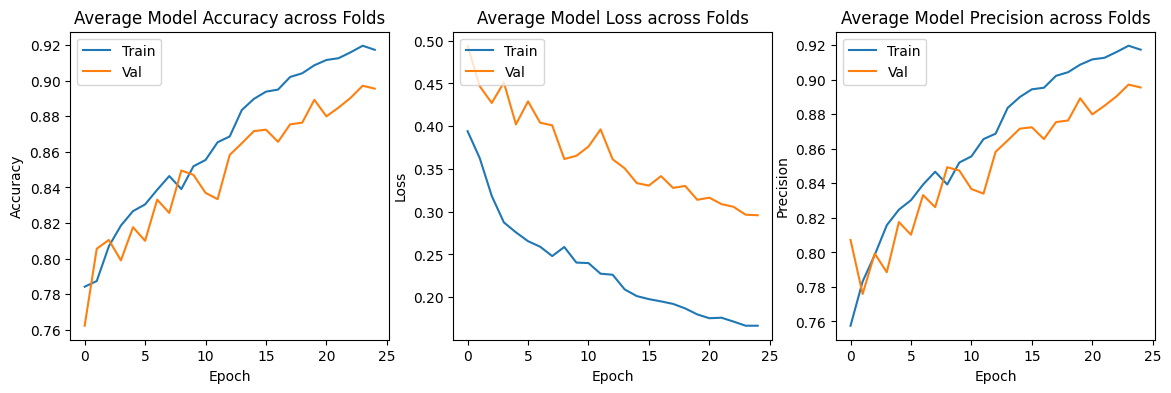

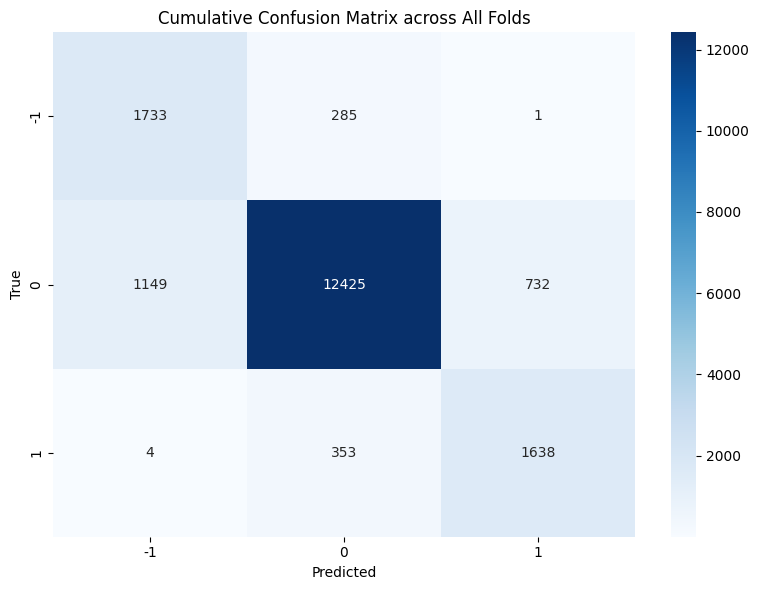

171/171 [==============================] - 2s 6ms/step
Shape of windowed_test_targets: (5459,)
Shape of test_predictions: (5459,)
Accuracy on hold-out test set: 0.90
Precision on hold-out test set: 0.92
Recall on hold-out test set: 0.90
F1 Score on hold-out test set: 0.91

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.90      0.77       515
           1       0.97      0.90      0.94      4247
           2       0.77      0.92      0.84       697

    accuracy                           0.90      5459
   macro avg       0.81      0.91      0.85      5459
weighted avg       0.92      0.90      0.91      5459



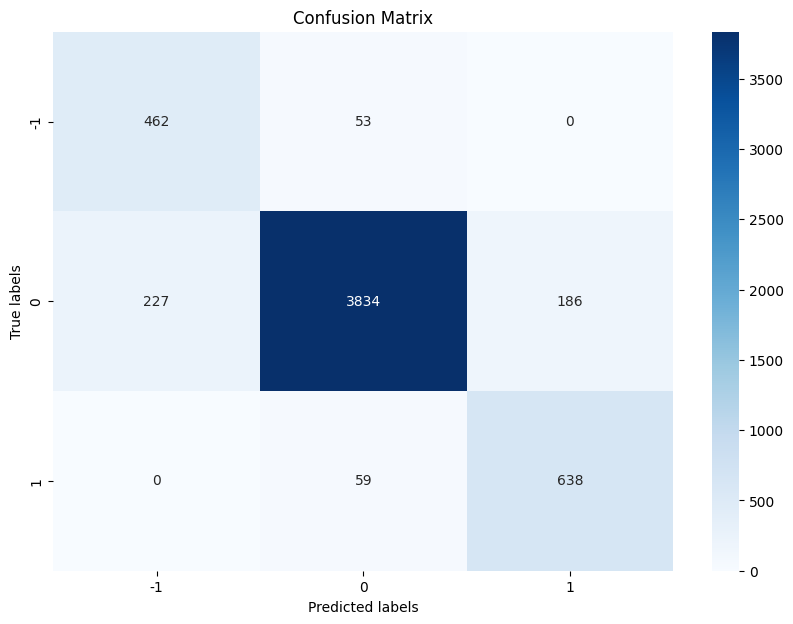

In [ ]:
batch_size = 64
epochs = 25
plot_results = True

windowed_train_data, windowed_train_targets, windowed_test_data, windowed_test_targets = create_model_windows(
    train_features, train_targets, test_features, test_targets, n_past)

lstm_model = create_lstm(n_past, len(input_columns), n_classes)
lstm_model, all_histories, cumulative_confusion_matrix = train_model(
    lstm_model,
    batch_size,
    epochs,
    n_past,
    windowed_train_data,
    windowed_train_targets,
    label_mapping,
    plot_results=plot_results
)

test_predictions = test_holdoutset(
    lstm_model,
    windowed_test_data,
    windowed_test_targets,
    label_mapping,
    plot_results=plot_results
)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import LSTM, Dense
import pickle

# Assuming the preprocess_data, create_lstm, train_model, test_holdoutset functions are defined elsewhere
# and that they work as intended for this dataset and problem.

def create_and_train_model(path, freq, n_past, n_future, thresholds, input_columns, short_window, medium_window, long_window, epochs, batch_size, plot_data, plot_results):
    df, windowed_train_data, windowed_train_targets, windowed_test_data, windowed_test_targets, label_mapping = preprocess_data(
        path,
        freq,
        n_past,
        n_future,
        thresholds,
        input_columns,
        short_window=short_window,
        medium_window=medium_window,
        long_window=long_window,
        plot_data=plot_data
    )
    n_classes = 3
    lstm_model = create_lstm(n_past, len(input_columns), n_classes)
    lstm_model, all_histories, cumulative_confusion_matrix = train_model(
        lstm_model,
        batch_size,
        epochs,
        n_past,
        windowed_train_data,
        windowed_train_targets,
        label_mapping,
        plot_results=plot_results
    )
    return lstm_model, windowed_test_data, windowed_test_targets, label_mapping

# Paths for saving models
model_paths = {
    'model_2': '/mnt/data/lstm_model_2.pkl',
    'model_4': '/mnt/data/lstm_model_4.pkl',
    'model_6': '/mnt/data/lstm_model_6.pkl'
}

path = '/content/datasets/solusd.csv'
freq = '60min'
n_past = 48

short_window=6
medium_window=12
long_window=24

factor = 1
n_past *= factor
n_future *= factor
short_window *= factor
medium_window *= factor
long_window *= factor
epochs = 10
batch_size = 64
plot_data = True
plot_results = True

# Training and saving models for n_future = 2, 4, 6
for n_future, thresholds in zip([2, 4, 6], [([0.1, 0.2], [-0.2, -0.1]), ([0.2, 0.4], [-0.4, -0.2]), ([0.3, 0.6], [-0.6, -0.3])]):
    model, test_data, test_targets, label_mapping = create_and_train_model(
        path=path,
        freq=freq,
        n_past=n_past,
        n_future=n_future,
        thresholds=thresholds,
        input_columns=INPUT_COLUMNS,
        short_window=short_window,
        medium_window=medium_window,
        long_window=long_window,
        epochs=epochs,
        batch_size=batch_size,
        plot_data=plot_data,
        plot_results=plot_results
    )

    # Save the model
    with open(model_paths[f'model_{n_future}'], 'wb') as file:
        pickle.dump(model, file)

# Load models for testing
models = {}
for n in [2, 4, 6]:
    with open(model_paths[f'model_{n}'], 'rb') as file:
        models[f'model_{n}'] = pickle.load(file)

# Test the loaded models (pseudo code, adjust based on actual testing function)
# This code assumes a function `test_model` exists which will take the loaded model and test data to perform the evaluation
for n in [2, 4, 6]:
    model = models[f'model_{n}']
    # Assuming test_model is a function to evaluate the model on the test set
    # Replace 'test_model' with the actual function name you have and pass the necessary arguments
    # test_predictions = test_model(model, test_data, test_targets, ...)
    # Do something with test_predictions

In [ ]:
def evaluate_model(path, freq, n_past, n_future, buy_thresholds, sell_thresholds, epochs, batch_size, plot_data=False, plot_results=False, plot_simulation=False):

    df, windowed_train_data, windowed_train_targets, windowed_test_data, windowed_test_targets = preprocess(path, freq, n_past, n_future, buy_thresholds, sell_thresholds, plot_data=plot_data)

    lstm_model = create_lstm(n_past, len(INPUT_COLUMNS))
    lstm_model, all_histories, cumulative_confusion_matrix = train_model(lstm_model, batch_size, epochs, n_past, windowed_train_data, windowed_train_targets, plot_results=plot_results)

    test_predictions = test_holdoutset(lstm_model, windowed_test_data, windowed_test_targets, plot_results=plot_results)

    predictions = ['hold' if pred == 0 else 'buy' if pred == 1 else 'sell' for pred in test_predictions]
    prices = df['close'].values[-len(predictions):]

    best_parameters, success_rate, final_capital, capital_over_time, entry_points, exit_points = grid_search_simulate_trades(df, predictions, prices)
    if plot_simulation:
        plot_simulation_results(prices, best_parameters, success_rate, final_capital, capital_over_time, entry_points, exit_points)

    return lstm_model, all_histories, cumulative_confusion_matrix, best_parameters, success_rate, final_capital, capital_over_time, entry_points, exit_points


In [ ]:
import pandas as pd
import numpy as np
import pickle

def save_progress(file_name, data):
    with open(file_name, 'wb') as file:
        pickle.dump(data, file)

def load_progress(file_name):
    try:
        with open(file_name, 'rb') as file:
            return pickle.load(file)
    except FileNotFoundError:
        return None

def generate_log_space(min_val, max_val, n):
    """ Generate logarithmically spaced numbers more dense towards zero within a given range. """
    assert min_val > 0, "min_val must be positive as logspace cannot start at zero."
    # Generate values between log10(min_val) and log10(max_val)
    log_min = np.log10(min_val)
    log_max = np.log10(max_val)
    result = np.logspace(log_min, log_max, num=n, base=10.0)
    return result

def grid_search(path, freq, n_past, epochs, batch_size, n_future_options, min_threshold, max_threshold, num_thresholds, progress_file):
    progress = load_progress(progress_file)
    if progress is None:
        progress = {}

    threshold_values = generate_log_space(min_threshold, max_threshold, num_thresholds)

    for n_future in n_future_options:
        for lower_threshold in threshold_values:
            for upper_threshold in threshold_values:
                if lower_threshold < upper_threshold:
                    buy_thresholds = [lower_threshold, upper_threshold, ]
                    sell_thresholds = [-upper_threshold, -lower_threshold]
                    key = (n_future, n_past, tuple(buy_thresholds), tuple(sell_thresholds), epochs, batch_size)
                    if key not in progress:
                        print(f"Running simulation for n_future={n_future}, buy_thresholds={buy_thresholds}, sell_thresholds={sell_thresholds}")
                        model, histories, confusion_matrix, best_params, success_rate, final_capital, capital_over_time, entry_points, exit_points = evaluate_model(
                            path, freq, n_past, n_future, buy_thresholds, sell_thresholds, epochs, batch_size, plot_data=False, plot_results=True, plot_simulation=True)

                        progress[key] = {
                            'model': model,
                            'histories': histories,
                            'confusion_matrix': confusion_matrix,
                            'best_parameters': best_params,
                            'success_rate': success_rate,
                            'final_capital': final_capital,
                            'capital_over_time': capital_over_time,
                            'entry_points': entry_points,
                            'exit_points': exit_points
                        }
                        save_progress(progress_file, progress)
                    else:
                        print(f"Skipping completed simulation for n_future={n_future}, buy_thresholds={buy_thresholds}, sell_thresholds={sell_thresholds}")

    return progress


# Define the range for n_future and threshold bounds
n_future_options = [3, 6, 9, 12]  # Example values for n_future
min_threshold = 0.02  # Small positive number close to zero
max_threshold = 0.12   # Upper bound of the threshold
num_thresholds = 5    # Number of thresholds in the log space

# Path to your dataset
path = '/content/datasets/solusd.csv'
freq = '60min'
n_past = 48
epochs = 20
batch_size = 32

# Start the grid search
progress_file = '/content/model_progress.pkl'
results = grid_search(path, freq, n_past, epochs, batch_size, n_future_options, min_threshold, max_threshold, num_thresholds, progress_file)

# You can print or analyze results as needed
print(results)

In [ ]:
import pickle

def load_pickle(file_name):
    try:
        with open(file_name, 'rb') as file:
            data = pickle.load(file)
        return data
    except Exception as e:
        print(f"Failed to load pickle file: {e}")
        return None

# Assuming the file name is 'model_progress.pkl'
data = load_pickle('/content/model_progress.pkl')

def find_best_models_on_metric(data, metric):
    best_score = float('-inf')
    best_models = []
    if data is not None:
        for key, value in data.items():
            if metric in value:
                score = value[metric]
                if score > best_score:
                    best_score = score
                    best_models = [key]
                elif score == best_score:
                    best_models.append(key)
    return best_models, best_score


def find_best_models(data, top_n=5, based_on='final_capital'):
    model_performances = []

    for key, value in data.items():
        if 'histories' in value:
            all_histories = value['histories']
            max_epochs = max(max(len(hist) for hist in all_histories[metric]) for metric in all_histories)

            # Function to pad histories to the same length
            def pad_history(hist, target_length, padding_value='last'):
                if padding_value == 'last':
                    padding_value = hist[-1]
                return np.concatenate([hist, np.full((target_length - len(hist)), padding_value)])

            # Calculate the mean of each metric across epochs
            mean_histories = {
                metric: np.mean(
                    np.vstack([pad_history(hist, max_epochs) for hist in all_histories[metric]]), axis=0
                ) for metric in all_histories
            }

            # Here, we extract the desired performance metric from the data
            if based_on in value:
                best_score = value[based_on]
                model_performances.append((key, best_score, mean_histories))
            else:
                best_val_accuracy = max(mean_histories['val_accuracy'])
                model_performances.append((key, best_val_accuracy, mean_histories))



    # Sort models by their best validation accuracy
    model_performances.sort(key=lambda x: x[1], reverse=True)

    # Select top N models
    top_models = model_performances[:top_n]

    # Plotting section for top N models
    for model_key, high_score, histories in top_models:
        print(f"Model {model_key} - Best Validation Accuracy: {max(histories['val_accuracy'])}")
        print(f"Score: {data[model_key]['success_rate']}, Final Capital: {data[model_key]['final_capital']}")
        print(f"Take Profit: {data[model_key]['best_parameters']['take_profit']}, Stop Loss: {data[model_key]['best_parameters']['stop_loss']}")
        plt.figure(figsize=(14, 4))

        # Accuracy plot
        plt.subplot(1, 3, 1)
        plt.plot(histories['accuracy'], label='Train')
        plt.plot(histories['val_accuracy'], label='Validation')
        plt.title(f'Accuracy')
        plt.legend()

        # Loss plot
        plt.subplot(1, 3, 2)
        plt.plot(histories['loss'], label='Train')
        plt.plot(histories['val_loss'], label='Validation')
        plt.title(f'Loss')
        plt.legend()

        # Precision plot
        plt.subplot(1, 3, 3)
        plt.plot(histories['precision'], label='Train')
        plt.plot(histories['val_precision'], label='Validation')
        plt.title(f'Precision')
        plt.legend()

        plt.tight_layout()
        plt.show()

    return [model[0] for model in top_models]



# Example usage: Find the best models based on 'success_rate'
best_model = find_best_models(data, based_on='nothing')